# Setup

## Imports

In [1]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

import torch
import torch.autograd.variable as Variable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from shutil import copyfile

# Preparing dataloaders

## **Raw data**



### Downloading data


We use the Adience dataset consisting unfiltered faces ([Link](http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/aligned.tar.gz)). Then, we unzip it.  
The first cell below downloads the data for you and places it in the **data** directory. The second cell unzips the data.

### Downloading folds

All five folds used in this paper are present [here](https://github.com/GilLevi/AgeGenderDeepLearning/tree/master/Folds/train_val_txt_files_per_fold). Download the **train_val_txt_files_per_fold** folder and place it in **My Drive/AgeGenderClassification/data**.


## Data loading

In [3]:
PATH_TO_FOLDS = "data/train_val_txt_files_per_fold"
PATH_TO_DATA = "data/"
PATH_TO_IMAGE_FOLDERS = PATH_TO_DATA + "aligned/"

In [4]:
# Notify me on completion by sound
from IPython.display import Audio
sound_file = '/root/beep-07a.wav'

#Audio(sound_file, autoplay=True)

### Creating a Dataset class

We create a class **`AdienceDataset`** that extends **`Dataset`**. This class helps us in feeding the input data to the network in minibatches.

[This](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) is a useful tutorial on how to load and augment data in PyTorch. 

In [5]:
class AdienceDataset(Dataset):
    
    def __init__(self, txt_file, root_dir, transform):
        self.txt_file = txt_file
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()
    
    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        f = open(self.txt_file)
        for line in f.readlines():
            image_file, label = line.split() 
            label = int(label)
            if 'gender' in self.txt_file:
                label += 8
            data.append((image_file, label))
        return data
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': label
        }
    
class AdienceDatasetCombined(Dataset):
    
    def __init__(self, txt_dir, subset, root_dir, transform):
        self.txt_dir = txt_dir
        self.subset = subset
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()
    
    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        data2 = []
        age_txt_file = f'{self.txt_dir}/age_{self.subset}.txt'
        gender_txt_file = f'{self.txt_dir}/gender_{self.subset}.txt'
        age_file = open(age_txt_file)        
        for line in age_file.readlines():
            image_file, label = line.split() 
            label = int(label)
            data.append((image_file, label))
        age_file.close()
        gender_file = open(gender_txt_file)
        for line in gender_file.readlines():
            image_file, label = line.split() 
            label = int(label)
            for record in data:
                if (record[0] == image_file):
                    data2.append((image_file, record[1] + 10*label))
                    break
        return data2
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': label
        }

### Transforms
Every image is first resized to a `256x256` image and then cropped to a `227x227` image before being fed to the network.

**`transforms_list`** is the list of transforms we would like to apply to the input data. Apart from training the neural network without any transformations, we can also train the network using the following transforms (also called as data augmentation techniques):
*   random horizontal flip
*   random crop and random horizontal flip

We don't perform any transformation on the images during validation and testing.


In [6]:
transforms_list = [
    transforms.Resize(256), # 0 (required)
    transforms.CenterCrop(227), #1 (required)
    transforms.RandomHorizontalFlip(), #2
    transforms.ToTensor(), #3 (required)
    transforms.RandomCrop(227) #4
]

# Adversarial training
# Look into increase or decrease contrast
# Look into principal component analysis (PCA) on the RGB colourspace

# Pre-training using the CelebA dataset http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
# Essentially, meaning getting parameters but not calculating accuracy

transforms_dict = {
    'train': {
        0: list(transforms_list[i] for i in [0, 1, 3]),        # no transformation
        1: list(transforms_list[i] for i in [0, 1, 2, 3]),     # random horizontal flip
        2: list(transforms_list[i] for i in [0, 4, 2, 3])      # random crop and random horizontal flip
    },
    'val': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    },
    'test': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    }
}

### Dataloader
The **`DataLoader`** class in PyTorch helps us iterate through the dataset. This is where we input **`minibatch_size`** to our algorithm.

In [7]:
def get_dataloader(s, c, fold, transform_index, minibatch_size):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender", or 'both'
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        minibatch_size: An integer.

    Returns:
        An instance of the DataLoader class.
    """
    root_dir = PATH_TO_IMAGE_FOLDERS
    if c == "both":
        txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}'
        transformed_dataset = AdienceDatasetCombined(txt_file, s, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
        dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True, num_workers=24)
        return dataloader
    else:
        txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}/{c}_{s}.txt'        
        transformed_dataset = AdienceDataset(txt_file, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
        dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True, num_workers=24)
        return dataloader    

# Network

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
PATH_TO_MODELS = "models_adv"

## Defining the network
This is the network as described in the [paper](https://talhassner.github.io/home/projects/cnn_agegender/CVPR2015_CNN_AgeGenderEstimation.pdf).

In [10]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 96, 7, stride = 4, padding = 1)
        self.pool1 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv2 = nn.Conv2d(96, 256, 5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm2 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv3 = nn.Conv2d(256, 384, 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm3 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.fc1 = nn.Linear(18816, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
  
        self.fc3 = nn.Linear(512, 18)
    
        self.apply(weights_init)

    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)

        x = F.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.norm2(x)
      
        x = F.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.norm3(x)
      
        x = x.view(-1, 18816)
        
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)
      
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)
      
        x = F.log_softmax(self.fc3(x), dim=1)
  
        return x

class NewNet(nn.Module):
    
    def __init__(self):
        super(NewNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 96, 7, stride = 4, padding = 1)
        self.pool1 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv2 = nn.Conv2d(96, 256, 5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm2 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv3 = nn.Conv2d(256, 384, 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm3 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.fc1 = nn.Linear(18816, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
  
        self.fc3 = nn.Linear(512, 18)
    
        self.apply(weights_init)

    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)

        x = F.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.norm2(x)
      
        x = F.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.norm3(x)
      
        x = x.view(-1, 18816)
        
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)
      
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)
      
        x = F.log_softmax(self.fc3(x), dim=1)
  
        return x

In [11]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=1e-2)

In [12]:
criterion = nn.NLLLoss()

## Hyperparameters
Try playing with these! While the **`minibatch_size`** and **`lr`** are pulled from the paper, **`num_epochs`** is set empirically. 

In [13]:
minibatch_size = 50
num_epochs = 200
lr = 0.0001  # initial learning rate
epsilon = 0.1
norm = np.inf
eps_iter = 0.01
nb_iter = 12

## Training the network
We save the network to the drive and compute the loss on validation set after every **`checkpoint_frequency`** number of iterations. We decrease the learning by a tenth after 10,000 iterations using the **`MultiStepLR`** class of PyTorch.

In [14]:
def train(net, train_dataloader, epochs, filename, checkpoint_frequency=50, val_dataloader=None, patience=None):
    """
    Args:
        net: An instance of PyTorch's Net class.
        train_dataloader: An instance of PyTorch's Dataloader class.
        epochs: An integer.
        filename: A string. Name of the model saved to drive.
        checkpoint_frequency: An integer. Represents how frequent (in terms
            of number of iterations) the model should be saved to drive.
        val_dataloader: An instance of PyTorch's Dataloader class.
    
    Returns:
        net: An instance of PyTorch's Net class. The trained network.
        training_loss: A list of numbers that represents the training loss at each checkpoint.
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    net.train()
    optimizer = optim.Adam(net.parameters(), lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000])
    
    training_loss, validation_loss = [], []
    checkpoint = 0
    iteration = 0
    running_loss = 0
    best_iteration = 1
    best_validation_loss = np.inf
    
    for epoch in range(epochs):
        
        for i, batch in enumerate(train_dataloader):
            scheduler.step()
            optimizer.zero_grad()
            images, labels = batch['image'].to(device), batch['label'].to(device)
            if iteration % 2 == 0:
                images = projected_gradient_descent(net, images, epsilon, eps_iter, nb_iter, norm)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += float(loss.item())
            loss.backward()
            optimizer.step()
            
            if (iteration+1) % checkpoint_frequency == 0 and val_dataloader is not None:
                if patience == None:
                    training_loss.append(running_loss/checkpoint_frequency)
                    validation_loss.append(validate(net, val_dataloader))
                    print(f'minibatch:{i}, epoch:{epoch+1}, iteration:{iteration}, training_error:{training_loss_result}, validation_error:{validation_loss_result}')
                    save_network(net, f'{filename}_checkpoint{checkpoint}')                        
                elif patience > 0:
                    training_loss_result = running_loss/checkpoint_frequency
                    validation_loss_result = validate(net, val_dataloader)
                    print(f'minibatch:{i}, epoch:{epoch+1}, iteration:{iteration}, training_error:{training_loss_result}, validation_error:{validation_loss_result}')
                    if best_validation_loss >= validation_loss_result:
                        print(f'Best loss improvement from {best_validation_loss} to {validation_loss_result} in epoch {epoch+1}')
                        best_validation_loss = validation_loss_result
                        best_epoch = epoch + 1
                        training_loss.append(training_loss_result)
                        validation_loss.append(validation_loss_result)
                        save_network(net, f'{filename}_checkpoint{checkpoint}')
                        best_iteration = iteration + 1
                    elif best_iteration + patience * checkpoint_frequency <= iteration:
                        print(f"Patience ran out at {iteration}. Ending training")
                        return net, training_loss, validation_loss
                    else:
                        training_loss.append(training_loss_result)
                        validation_loss.append(validation_loss_result)
                checkpoint += 1
                running_loss = 0
            iteration += 1

    return net, training_loss, validation_loss

## Validation
We evaluate the performance (in terms of loss) of the trained network on validation set.

In [15]:
def validate(net, dataloader):
    net.train()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += float(loss.item())

    return total_loss/(i+1)

In [16]:
def get_validation_error(c, fold, train_transform_index):
    filename = get_model_filename(c, fold, train_transform_index)
    net = Net().to(device)
    net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
    return validate(net, get_dataloader('val', c, fold, 0, minibatch_size))

## Testing
We evaluate the performance (in terms of accuracy) of the trained network on the test set.

In [17]:
def test(net, dataloader, c):
    result = {
        'exact_match': 0,
        'total': 0
    }
    if c != 'gender':
        result['one_off_match'] = 0
    if c == 'both':
        result['gender_match'] = 0
        result['age_match'] = 0
        result['one_off_age_match'] = 0

    with torch.no_grad():
        net.eval()
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            outputs = torch.tensor(list(map(lambda x: torch.max(x, 0)[1], outputs))).to(device)
            result['total'] += len(outputs)
            result['exact_match'] += sum(outputs == labels).item()
            if c != 'gender':
                result['one_off_match'] += (sum(outputs==labels) +
                                            sum(outputs==labels-1) +
                                            sum(outputs==labels+1)).item()
            if c == 'both':
                for count, o in enumerate(outputs):
                    o = o.item()
                    if o <= 7: # male
                        if labels[count].item() >= 0 and labels[count].item() <= 7:
                            result['gender_match'] += 1
                        if labels[count].item() == o or labels[count].item() == o + 7:
                            result['age_match'] += 1
                            result['one_off_age_match'] += 1
                        if labels[count].item() == o + 1 or labels[count].item() == o - 1 \
                        or labels[count].item() == o + 8 or labels[count].item() == o + 6:
                            result['one_off_age_match'] += 1
                    elif o >= 10: # female
                        if labels[count].item() >= 10:
                            result['gender_match'] += 1
                        if labels[count].item() == o or labels[count].item() == o - 7:
                            result['age_match'] += 1
                            result['one_off_age_match'] += 1
                        if labels[count].item() == o + 1 or labels[count].item() == o - 1 \
                        or labels[count].item() == o - 8 or labels[count].item() == o - 6:
                            result['one_off_age_match'] += 1

    return result           

## Saving the network

In [18]:
def save_network(net, filename):
    torch.save(net.state_dict(), f'{PATH_TO_MODELS}/{filename}.pt')

# Execution

### Picking the best model for a fold
**`train_save()`** trains the network using the **`train()`** function and then, using the validation losses returned by this function at all checkpoints, chooses the model with least validation error. This function also plots a graph of training and validation errors over the iterations.

**Usage:**

For e.g., if you want to train the network for **`age`** using **`fold=2`** and **`train_transform_index=2`**,
```
train_save('age', 2, 2)
```



In [19]:
def train_save(c, fold, train_transform_index, checkpoint_frequency=50, patience=10):
    """
    Args:
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        train_transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        checkpoint_frequency: An integer. Represents how frequent (in terms
            of number of iterations) the model should be saved to drive.   
    Returns:
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    if c != "both":
        trained_net, training_loss, validation_loss = train(
            Net().to(device),
            get_dataloader('train', c, fold, train_transform_index, minibatch_size),
            num_epochs,
            f'{fold}_{c}_train_{train_transform_index}',
            checkpoint_frequency,
            get_dataloader('val', c, fold, 0, minibatch_size),
            patience=patience
        )

        plt.plot(list(range(1, len(validation_loss)+1)), validation_loss, label='validation_loss')
        plt.plot(list(range(1, len(training_loss)+1)), training_loss, label='training_loss')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.show()

        choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss)

        return validation_loss
    else:
        trained_net, training_loss, validation_loss = train(
            NewNet().to(device),
            get_dataloader('train', c, fold, train_transform_index, minibatch_size),
            num_epochs,
            f'{fold}_{c}_train_{train_transform_index}',
            checkpoint_frequency,
            get_dataloader('val', c, fold, 0, minibatch_size),
            patience=patience
        )

        plt.plot(list(range(1, len(validation_loss)+1)), validation_loss, label='validation_loss')
        plt.plot(list(range(1, len(training_loss)+1)), training_loss, label='training_loss')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.show()

        choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss)

        return validation_loss

In [20]:
def choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss):
    index = validation_loss.index(min(validation_loss))
    filename = f'{fold}_{c}_train_{train_transform_index}'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(filename):
            if file.startswith(f'{filename}_checkpoint{index}'):
                pass
            else:
                os.remove(f'{PATH_TO_MODELS}/{file}')

### Picking the best model among all the folds

Using **`pick_best_model()`**, we can pick the model among various folds that gives us the best validation accuracy. The best model's name is appended with **_best **in the **models** directory. 

**Usage:**

To pick the best model for **`age`**,
```
pick_best_model('age')
```


To pick the best model for **`gender`**,

```
pick_best_model('gender')
```

In [21]:
def pick_best_model(c):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age", "gender" or "both".
    """
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 5 and file_split[1] == c) else False
    
    def fn_map(file):
        file_split = file.split('_')
        return get_validation_error(c, file_split[0], file_split[3])
    
    files = list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))
    val_errors = list(map(fn_map, files))
    min_val_error, file = min(zip(val_errors, files))
    best_model = f'{PATH_TO_MODELS}/{file.split(".")[0]}_best.pt'
    copyfile(f'{PATH_TO_MODELS}/{file}', best_model)
    
    print(f'Picking {best_model} as the best model for {c}...')

### Calculating performance/accuracy

We can check the performance of any model using the **`get_performance()`** function.

**Usage:**

To know the performance on **`age`** classification,
```
get_performance('age')
```


To know the performance on **`gender`** classification,

```
get_performance('gender')
```



In [22]:
def get_performance(c):
    """
    Args:
        c: A string. Equals either "age" or "gender".
    Returns:
        A dictionary containing accuracy (and one-off accuracy for age) of the model.
    """    
    file = get_best_model_filename(c).split('_')
    return get_performance_of_a_model('test', file[1], file[0], file[3])

In [23]:
def get_best_model_filename(c):
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 6 and file_split[1] == c) else False
    
    return list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))[0]

In [24]:
def get_performance_of_a_model(s, c, fold, train_transform_index):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
    Returns:
        A dictionary containing accuracy (and one-off accuracy for age) of the model.
    """
    filename = get_model_filename(c, fold, train_transform_index)
    if c != "both":
        net = Net().to(device)
        net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
        performance = test(
            net,
            get_dataloader(s, c, fold, 0, minibatch_size),
            c
        )
        if c != 'gender':
            return {
                'accuracy': performance['exact_match']/performance['total'],
                'one-off accuracy': performance['one_off_match']/performance['total']
            }
        else:
            return {
                'accuracy': performance['exact_match']/performance['total']
            }
    else:
        net = NewNet().to(device)
        net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
        performance = test(
            net,
            get_dataloader(s, c, fold, 0, minibatch_size),
            c
        )
        return {
            'accuracy': performance['exact_match']/performance['total'],
            'one-off accuracy': performance['one_off_match']/performance['total'],
            'gender accuracy': performance['gender_match']/performance['total'],
            'age accuracy': performance['age_match']/performance['total'],
            'one-off age accuracy': performance['one_off_age_match']/performance['total']
        }

In [25]:
def get_model_filename(c, fold, train_transform_index):
    start_of_filename = f'{fold}_{c}_train_{train_transform_index}_checkpoint'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(start_of_filename):
            return file

In [26]:
print(NewNet())

NewNet(
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm3): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=18, bias=True)
)


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


minibatch:49, epoch:1, iteration:49, training_error:4.518419594764709, validation_error:4.8552209337552386
Best loss improvement from inf to 4.8552209337552386 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.503096809387207, validation_error:4.704124788443248
Best loss improvement from 4.8552209337552386 to 4.704124788443248 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:4.51982946395874, validation_error:4.603959997495015
Best loss improvement from 4.704124788443248 to 4.603959997495015 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:4.458160996437073, validation_error:4.572843412558238
Best loss improvement from 4.603959997495015 to 4.572843412558238 in epoch 1
minibatch:25, epoch:2, iteration:249, training_error:4.489384145736694, validation_error:4.589027961095174
minibatch:75, epoch:2, iteration:299, training_error:4.458021268844605, validation_error:4.545251369476318
Best loss improvement from 4.572843412558238 to 4.545251369476

minibatch:13, epoch:15, iteration:3149, training_error:3.4526144456863403, validation_error:2.8928659756978354
minibatch:63, epoch:15, iteration:3199, training_error:3.688031482696533, validation_error:3.1930314004421234
minibatch:113, epoch:15, iteration:3249, training_error:4.091068277359009, validation_error:3.9894077281157174
minibatch:163, epoch:15, iteration:3299, training_error:3.7596944761276245, validation_error:3.208360264698664
minibatch:213, epoch:15, iteration:3349, training_error:3.7567265701293944, validation_error:3.828077087799708
minibatch:39, epoch:16, iteration:3399, training_error:3.794348802566528, validation_error:5.925429026285808
Patience ran out at 3399. Ending training


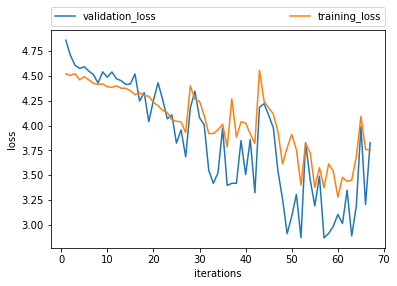

[4.8552209337552386,
 4.704124788443248,
 4.603959997495015,
 4.572843412558238,
 4.589027961095174,
 4.545251369476318,
 4.510042071342468,
 4.426441669464111,
 4.538157383600871,
 4.484563132127126,
 4.536873002847035,
 4.468901455402374,
 4.44964720805486,
 4.411862214406331,
 4.4159175753593445,
 4.517623662948608,
 4.245529095331828,
 4.330389499664307,
 4.038913697004318,
 4.250967045625051,
 4.427916377782822,
 4.261714110771815,
 4.06665222843488,
 4.107540716727574,
 3.823243031899134,
 3.9557929635047913,
 3.685656269391378,
 4.175451775391896,
 4.344764510790507,
 4.077739715576172,
 4.008817940950394,
 3.5507787068684897,
 3.4197707374890647,
 3.524831235408783,
 3.9742386837800345,
 3.3995862901210785,
 3.4198129574457803,
 3.421357274055481,
 3.8492047687371573,
 3.508438358704249,
 3.860250393549601,
 3.32608171304067,
 4.183929522832234,
 4.218597739934921,
 4.102162490288417,
 3.9776462515195212,
 3.5433591107527413,
 3.2630068163077035,
 2.9149186611175537,
 3.0899324

In [27]:
train_save('both', 0, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:4.495504140853882, validation_error:4.5588962237040205
Best loss improvement from inf to 4.5588962237040205 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.52725124835968, validation_error:4.770684401194255
minibatch:149, epoch:1, iteration:149, training_error:4.4995631504058835, validation_error:4.509751885025589
Best loss improvement from 4.5588962237040205 to 4.509751885025589 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:4.451653327941894, validation_error:4.531347345422815
minibatch:10, epoch:2, iteration:249, training_error:4.392470579147339, validation_error:4.654614007031476
minibatch:60, epoch:2, iteration:299, training_error:4.442629628181457, validation_error:4.5454702907138405
minibatch:110, epoch:2, iteration:349, training_error:4.409115915298462, validation_error:4.551660272810194
minibatch:160, epoch:2, iteration:399, training_error:4.426936197280884, validation_error:4.39679062808001

minibatch:142, epoch:14, iteration:3249, training_error:3.18067259311676, validation_error:2.9766653378804526
Patience ran out at 3249. Ending training


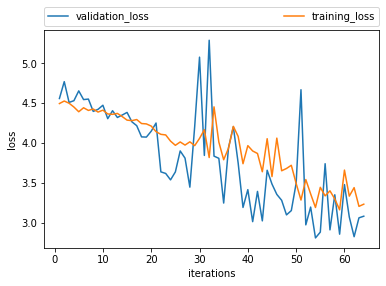

[4.5588962237040205,
 4.770684401194255,
 4.509751885025589,
 4.531347345422815,
 4.654614007031476,
 4.5454702907138405,
 4.551660272810194,
 4.396790628080015,
 4.423148278836851,
 4.474302168245669,
 4.305740639015481,
 4.405366191157588,
 4.320417686744973,
 4.35135394555551,
 4.3839724328782825,
 4.266230539039329,
 4.217559169839929,
 4.076615872206511,
 4.073906236224705,
 4.148035923639934,
 4.2506747687304465,
 3.6370885283858687,
 3.617021331080684,
 3.5364699716921204,
 3.636395012890851,
 3.9000215000576444,
 3.809239078451086,
 3.4449204515527794,
 4.206711407060976,
 5.07840613965635,
 3.843584334408795,
 5.291085914329246,
 3.834835926691691,
 3.8070085136978715,
 3.2451668933585838,
 3.9414126254894115,
 4.2049402130974665,
 3.746630721622043,
 3.1899225888428866,
 3.413395148736459,
 3.0113533867730036,
 3.391330630690963,
 3.0211665630340576,
 3.6571346565529153,
 3.48347724808587,
 3.3537746712013528,
 3.2796744858777083,
 3.0965306847183793,
 3.150326481571904,
 3.4

In [28]:
train_save('both', 1, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:4.229064707756042, validation_error:4.823365582360162
Best loss improvement from inf to 4.823365582360162 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.0505649185180665, validation_error:4.166080642629553
Best loss improvement from 4.823365582360162 to 4.166080642629553 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:4.053624415397644, validation_error:4.196814227987219
minibatch:199, epoch:1, iteration:199, training_error:4.096598768234253, validation_error:4.151115037776806
Best loss improvement from 4.166080642629553 to 4.151115037776806 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:4.047275409698487, validation_error:4.171879900826348
minibatch:62, epoch:2, iteration:299, training_error:4.026517782211304, validation_error:4.070794061378196
Best loss improvement from 4.151115037776806 to 4.070794061378196 in epoch 2
minibatch:112, epoch:2, iteration:349, training_error:3.9753440

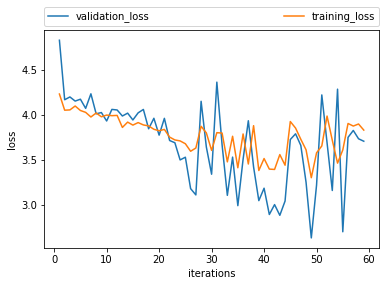

[4.823365582360162,
 4.166080642629553,
 4.196814227987219,
 4.151115037776806,
 4.171879900826348,
 4.070794061378196,
 4.23157360818651,
 4.01069415057147,
 4.024409294128418,
 3.9310290018717446,
 4.059257975331059,
 4.052833389352869,
 3.9862626217029713,
 4.017992037313956,
 3.942575905058119,
 4.021205646020395,
 4.0588216075190795,
 3.845216892383717,
 3.9612058621865733,
 3.7749283048841686,
 3.9605624322538024,
 3.7155060503217907,
 3.691011411172372,
 3.501089475772999,
 3.5309977619736284,
 3.1840279278931796,
 3.1145570278167725,
 4.148848648424502,
 3.643388695187039,
 3.343081898159451,
 4.360371642642551,
 3.6664393742879233,
 3.1097358862559,
 3.5322473490679704,
 2.995800353862621,
 3.508081489139133,
 3.9340763886769614,
 3.4235632331283004,
 3.051416785628707,
 3.188578658633762,
 2.898074194237038,
 3.007254159009015,
 2.889128075705634,
 3.0467020670572915,
 3.7266952020150645,
 3.789592416198165,
 3.661238529064037,
 3.253973360414858,
 2.6393666708910906,
 3.2227

In [29]:
train_save('both', 2, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:4.417912745475769, validation_error:5.562243232020625
Best loss improvement from inf to 5.562243232020625 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.580749096870423, validation_error:4.763403751232006
Best loss improvement from 5.562243232020625 to 4.763403751232006 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:4.509730758666993, validation_error:4.60790655348036
Best loss improvement from 4.763403751232006 to 4.60790655348036 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:4.450505843162537, validation_error:4.663401727323179
minibatch:8, epoch:2, iteration:249, training_error:4.462590646743775, validation_error:4.610471495875606
minibatch:58, epoch:2, iteration:299, training_error:4.439825735092163, validation_error:4.507116353070295
Best loss improvement from 4.60790655348036 to 4.507116353070295 in epoch 2
minibatch:108, epoch:2, iteration:349, training_error:4.454233942031

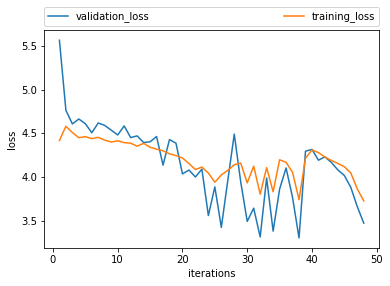

[5.562243232020625,
 4.763403751232006,
 4.60790655348036,
 4.663401727323179,
 4.610471495875606,
 4.507116353070295,
 4.618558035956489,
 4.590203020307753,
 4.536567511381926,
 4.4818415288571956,
 4.584802168386954,
 4.451988149572302,
 4.471125161206281,
 4.395692242516412,
 4.40363269382053,
 4.464114648324472,
 4.137887513196027,
 4.429397830256709,
 4.387587547302246,
 4.037454958315249,
 4.0815938578711615,
 4.002358083371763,
 4.09184898270501,
 3.562438399703414,
 3.8893270139341003,
 3.427254067526923,
 3.962622086207072,
 4.491147818388762,
 3.9443010224236383,
 3.4957799911499023,
 3.646459968001754,
 3.3185482113449662,
 3.990253801699038,
 3.3843395003566035,
 3.863830080738774,
 4.105191274925515,
 3.7687848850532815,
 3.3071662231727883,
 4.296469414675677,
 4.3166391937821,
 4.194328864415486,
 4.231158909974275,
 4.167795075310601,
 4.082703510920207,
 4.019040443279125,
 3.8829336519594544,
 3.6629113886091442,
 3.4756803777482776]

In [30]:
train_save('both', 3, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:4.233357343673706, validation_error:4.80819937816033
Best loss improvement from inf to 4.80819937816033 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.1568622350692745, validation_error:4.097749013167161
Best loss improvement from 4.80819937816033 to 4.097749013167161 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:4.08764431476593, validation_error:4.130100690401518
minibatch:199, epoch:1, iteration:199, training_error:4.006127157211304, validation_error:4.174678674110999
minibatch:17, epoch:2, iteration:249, training_error:4.01980906009674, validation_error:4.112111082443824
minibatch:67, epoch:2, iteration:299, training_error:3.9617797183990477, validation_error:4.254213975026057
minibatch:117, epoch:2, iteration:349, training_error:4.0690107345581055, validation_error:4.018088450798621
Best loss improvement from 4.097749013167161 to 4.018088450798621 in epoch 2
minibatch:167, epoch:2, iteration:3

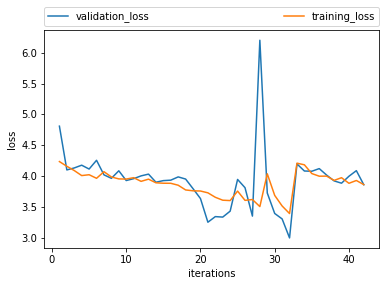

[4.80819937816033,
 4.097749013167161,
 4.130100690401518,
 4.174678674110999,
 4.112111082443824,
 4.254213975026057,
 4.018088450798621,
 3.961618863619291,
 4.0837539709531345,
 3.925687450629014,
 3.9558971294989953,
 4.001166132780222,
 4.029764523872962,
 3.8982957143049974,
 3.924211171957163,
 3.931635563190167,
 3.984588916485126,
 3.949627454464252,
 3.7931475180845995,
 3.633163516338055,
 3.248777545415438,
 3.3399137533628025,
 3.332020035156837,
 3.4286294350257287,
 3.943136637027447,
 3.809570541748634,
 3.3481575892521787,
 6.203365546006423,
 3.7230298610833974,
 3.3908640146255493,
 3.302271980505723,
 2.99395345724546,
 4.195480603438157,
 4.080264797577491,
 4.076354035964379,
 4.1193620058206415,
 4.013541194108816,
 3.9200106217310977,
 3.88236770263085,
 3.9950103851465077,
 4.0858748601033135,
 3.857395960734441]

In [31]:
train_save('both', 4, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:4.199482440948486, validation_error:5.274607261021932
Best loss improvement from inf to 5.274607261021932 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.209999399185181, validation_error:4.253649493058522
Best loss improvement from 5.274607261021932 to 4.253649493058522 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:4.1585708475112915, validation_error:4.113789925972621
Best loss improvement from 4.253649493058522 to 4.113789925972621 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:4.0960374402999875, validation_error:4.293926815191905
minibatch:25, epoch:2, iteration:249, training_error:4.0537886762619015, validation_error:4.188826620578766
minibatch:75, epoch:2, iteration:299, training_error:4.0443148422241215, validation_error:4.1792261600494385
minibatch:125, epoch:2, iteration:349, training_error:4.064715571403504, validation_error:4.1811845401922865
minibatch:175, epoch:2, ite

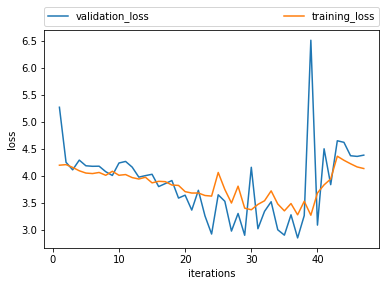

[5.274607261021932,
 4.253649493058522,
 4.113789925972621,
 4.293926815191905,
 4.188826620578766,
 4.1792261600494385,
 4.1811845401922865,
 4.079028646151225,
 4.009235243002574,
 4.240241001049678,
 4.269513716300328,
 4.163347035646439,
 3.9781596263249717,
 4.005941331386566,
 4.031028191248576,
 3.802565266688665,
 3.85857563217481,
 3.9148520032564798,
 3.589478095372518,
 3.643547515074412,
 3.366783926884333,
 3.733783016602198,
 3.2585607369740806,
 2.9225713312625885,
 3.6499429245789847,
 3.5300334692001343,
 2.977132797241211,
 3.303576111793518,
 2.8993387520313263,
 4.160761743783951,
 3.0208739042282104,
 3.343051850795746,
 3.5219275057315826,
 3.001083920399348,
 2.9016063809394836,
 3.279051731030146,
 2.8502861062685647,
 3.2643457849820456,
 6.518119156360626,
 3.0879584153493247,
 4.504261573155721,
 3.8383641242980957,
 4.652947902679443,
 4.623835921287537,
 4.375114341576894,
 4.362827291091283,
 4.386210093895595]

In [32]:
train_save('both', 0, 1)

minibatch:49, epoch:1, iteration:49, training_error:4.4413114213943485, validation_error:5.136808254100658
Best loss improvement from inf to 5.136808254100658 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.552564625740051, validation_error:4.6008367715058505
Best loss improvement from 5.136808254100658 to 4.6008367715058505 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:4.495974588394165, validation_error:4.557237360212538
Best loss improvement from 4.6008367715058505 to 4.557237360212538 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:4.457274761199951, validation_error:4.582755530322039
minibatch:10, epoch:2, iteration:249, training_error:4.412533235549927, validation_error:4.535956117841932
Best loss improvement from 4.557237360212538 to 4.535956117841932 in epoch 2
minibatch:60, epoch:2, iteration:299, training_error:4.399357786178589, validation_error:4.528255533289026
Best loss improvement from 4.535956117841932 to 4.5282555332

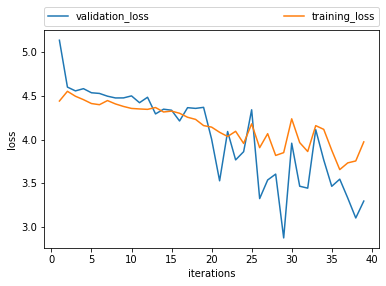

[5.136808254100658,
 4.6008367715058505,
 4.557237360212538,
 4.582755530322039,
 4.535956117841932,
 4.528255533289026,
 4.496728331954391,
 4.4765289447925705,
 4.4770838066383645,
 4.500033343279803,
 4.422203946996619,
 4.484525556917544,
 4.29388662620827,
 4.347957416816994,
 4.336171556402136,
 4.213106332001863,
 4.365348321420175,
 4.357158325336598,
 4.369105851208722,
 4.0056505468156605,
 3.528638380545157,
 4.092655835328279,
 3.7677753501468234,
 3.86195319670218,
 4.34120774269104,
 3.3252431198402688,
 3.5379577212863498,
 3.60527029743901,
 2.8751377352961787,
 3.958848343955146,
 3.4665562400111445,
 3.4444340070088706,
 4.113984293407864,
 3.7673077759919344,
 3.4656461079915366,
 3.5472672250535755,
 3.3310843485373036,
 3.103329164010507,
 3.296758492787679]

In [33]:
train_save('both', 1, 1)

minibatch:49, epoch:1, iteration:49, training_error:4.496887745857239, validation_error:4.455368077313459
Best loss improvement from inf to 4.455368077313459 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.457594013214111, validation_error:4.641062471601698
minibatch:149, epoch:1, iteration:149, training_error:4.442426300048828, validation_error:4.569506821808992
minibatch:199, epoch:1, iteration:199, training_error:4.402774229049682, validation_error:4.585431893666585
minibatch:12, epoch:2, iteration:249, training_error:4.418203182220459, validation_error:4.537002333888301
minibatch:62, epoch:2, iteration:299, training_error:4.37746883392334, validation_error:4.623106320699056
minibatch:112, epoch:2, iteration:349, training_error:4.388233509063721, validation_error:4.476380401187473
minibatch:162, epoch:2, iteration:399, training_error:4.359479842185974, validation_error:4.572974593551071
minibatch:212, epoch:2, iteration:449, training_error:4.377025504112243, validat

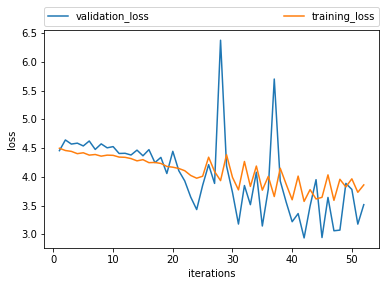

[4.455368077313459,
 4.641062471601698,
 4.569506821808992,
 4.585431893666585,
 4.537002333888301,
 4.623106320699056,
 4.476380401187473,
 4.572974593551071,
 4.504331994939734,
 4.525270868230749,
 4.405928099596942,
 4.409305378242776,
 4.37947577017325,
 4.4642162852817115,
 4.365661691736292,
 4.472790665096706,
 4.247496975792779,
 4.337880558437771,
 4.057789502320467,
 4.44349460248594,
 4.107144329282972,
 3.928589591273555,
 3.647904042844419,
 3.4307407008277044,
 3.8523759841918945,
 4.211373894302933,
 3.8852902871591075,
 6.37511071452388,
 4.191185686323378,
 3.7284585811473705,
 3.17870181578177,
 3.8485470436237477,
 3.515705276418615,
 4.079816526836819,
 3.144750983626754,
 3.7857400134757713,
 5.700706375969781,
 3.928420243439851,
 3.5583907145041005,
 3.219464655275698,
 3.3608972408153392,
 2.9376147676397255,
 3.4910757453353316,
 3.950403646186546,
 2.944211968669185,
 3.6416000436853477,
 3.0618941960511386,
 3.0733491756297924,
 3.8856812141559742,
 3.781097

In [34]:
train_save('both', 2, 1)

minibatch:49, epoch:1, iteration:49, training_error:4.471750178337097, validation_error:4.859372439207854
Best loss improvement from inf to 4.859372439207854 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.504107475280762, validation_error:4.734608314655445
Best loss improvement from 4.859372439207854 to 4.734608314655445 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:4.495714616775513, validation_error:4.628655875170672
Best loss improvement from 4.734608314655445 to 4.628655875170672 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:4.497117314338684, validation_error:4.5804943508572045
Best loss improvement from 4.628655875170672 to 4.5804943508572045 in epoch 1
minibatch:8, epoch:2, iteration:249, training_error:4.443487944602967, validation_error:4.586355438938847
minibatch:58, epoch:2, iteration:299, training_error:4.4081733560562135, validation_error:4.646872732374403
minibatch:108, epoch:2, iteration:349, training_error:4.433480

minibatch:16, epoch:14, iteration:3149, training_error:3.894382128715515, validation_error:3.0098229072712086
minibatch:66, epoch:14, iteration:3199, training_error:3.56358540058136, validation_error:3.6112319186881736
minibatch:116, epoch:14, iteration:3249, training_error:3.3608907318115233, validation_error:2.666900714238485
Best loss improvement from 2.7258987691667347 to 2.666900714238485 in epoch 14
minibatch:166, epoch:14, iteration:3299, training_error:3.635226397514343, validation_error:3.774552274633337
minibatch:216, epoch:14, iteration:3349, training_error:3.6436249685287474, validation_error:2.825954799298887
minibatch:25, epoch:15, iteration:3399, training_error:3.3474697971343996, validation_error:4.655022762439869
minibatch:75, epoch:15, iteration:3449, training_error:4.0185933113098145, validation_error:5.252047238526521
minibatch:125, epoch:15, iteration:3499, training_error:3.5041834354400634, validation_error:2.7578376752358897
minibatch:175, epoch:15, iteration:354

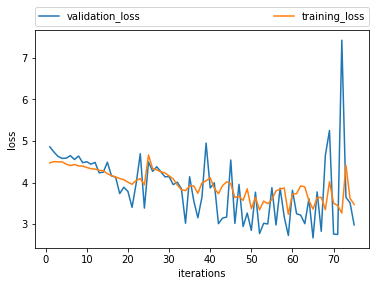

[4.859372439207854,
 4.734608314655445,
 4.628655875170672,
 4.5804943508572045,
 4.586355438938847,
 4.646872732374403,
 4.555158862361202,
 4.636944011405662,
 4.47831282792268,
 4.499770588344997,
 4.441563800529197,
 4.485293900525129,
 4.233316748230545,
 4.248761459633156,
 4.488318920135498,
 4.158314033790871,
 4.133126232359144,
 3.733485813494082,
 3.8871330596782543,
 3.785356539267081,
 3.4020452234480114,
 3.9774709277682834,
 4.693307346767849,
 3.3845444520314536,
 4.495819762901023,
 4.269790084273727,
 4.380055992691605,
 4.260541227128771,
 4.137328518761529,
 4.143606185913086,
 3.948743078443739,
 4.009073204464382,
 3.8503377702501087,
 3.0193277111759893,
 4.139524477499503,
 3.562072100462737,
 3.150912470287747,
 3.6502051794970476,
 4.9498021161114725,
 3.868949563414962,
 3.9919377079716436,
 3.009515409116392,
 3.143852048450046,
 3.168842527601454,
 4.542229899653682,
 3.0165229196901673,
 3.9555672892817744,
 2.9405769330483897,
 3.265253614496302,
 2.84813

In [35]:
train_save('both', 3, 1)

In [ ]:
train_save('both', 4, 1)

minibatch:49, epoch:1, iteration:49, training_error:4.45054141998291, validation_error:4.958009481430054
Best loss improvement from inf to 4.958009481430054 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.524535598754883, validation_error:4.580707450707753
Best loss improvement from 4.958009481430054 to 4.580707450707753 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:4.450810956954956, validation_error:4.577194352944692
Best loss improvement from 4.580707450707753 to 4.577194352944692 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:4.4541356563568115, validation_error:4.611730178197225
minibatch:25, epoch:2, iteration:249, training_error:4.465674800872803, validation_error:4.5388935307661695
Best loss improvement from 4.577194352944692 to 4.5388935307661695 in epoch 2
minibatch:75, epoch:2, iteration:299, training_error:4.429974546432495, validation_error:4.506771365801494
Best loss improvement from 4.5388935307661695 to 4.50677136580

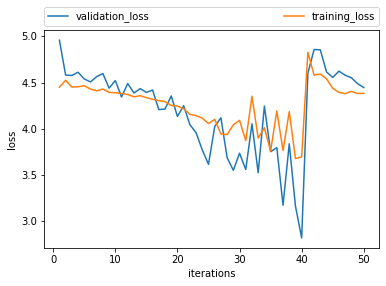

[4.958009481430054,
 4.580707450707753,
 4.577194352944692,
 4.611730178197225,
 4.5388935307661695,
 4.506771365801494,
 4.564287145932515,
 4.597471316655477,
 4.4398186802864075,
 4.521660019954045,
 4.34376589457194,
 4.489121496677399,
 4.386999050776164,
 4.434401075045268,
 4.393287628889084,
 4.419294873873393,
 4.207436114549637,
 4.2136644919713335,
 4.35521936416626,
 4.133128712574641,
 4.249566415945689,
 4.0446605285008745,
 3.957438757022222,
 3.7706508139769235,
 3.6148707071940103,
 4.023813446362813,
 4.1186133821805315,
 3.6871462364991507,
 3.5500219961007438,
 3.7353122731049857,
 3.5590789020061493,
 4.052981416384379,
 3.523867597182592,
 4.245265752077103,
 3.7518969774246216,
 3.7955251236756644,
 3.172654370466868,
 3.836367587248484,
 3.1628412902355194,
 2.818483829498291,
 4.6009959777196245,
 4.8575883110364275,
 4.854330996672313,
 4.615053455034892,
 4.555523176987966,
 4.623718321323395,
 4.579740802447001,
 4.552293260892232,
 4.488254229227702,
 4.446

In [37]:
train_save('both', 0, 2)

minibatch:49, epoch:1, iteration:49, training_error:4.509149479866028, validation_error:4.814587787345603
Best loss improvement from inf to 4.814587787345603 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.529402461051941, validation_error:4.646616352929009
Best loss improvement from 4.814587787345603 to 4.646616352929009 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:4.462975997924804, validation_error:4.606024300610578
Best loss improvement from 4.646616352929009 to 4.606024300610578 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:4.473239898681641, validation_error:4.617574903700087
minibatch:10, epoch:2, iteration:249, training_error:4.458405513763427, validation_error:4.586908905594437
Best loss improvement from 4.606024300610578 to 4.586908905594437 in epoch 2
minibatch:60, epoch:2, iteration:299, training_error:4.401338601112366, validation_error:4.587668065671568
minibatch:110, epoch:2, iteration:349, training_error:4.42048079

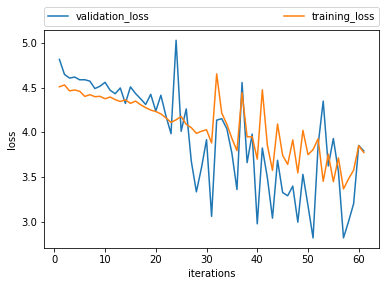

[4.814587787345603,
 4.646616352929009,
 4.606024300610578,
 4.617574903700087,
 4.586908905594437,
 4.587668065671568,
 4.57202888418127,
 4.489087475670709,
 4.515396683304398,
 4.558764704951534,
 4.4695336995301425,
 4.43153300108733,
 4.495658980475532,
 4.322744987629078,
 4.507425944010417,
 4.4340568471837924,
 4.375130812327067,
 4.311040966599076,
 4.424374032903601,
 4.237791926772506,
 4.414456561759666,
 4.183346395139341,
 3.9844624907882125,
 5.028955124042652,
 4.011412108386004,
 4.261603964699639,
 3.6761114685623735,
 3.3344433395950883,
 3.6025104699311434,
 3.9175838541101524,
 3.060373818432843,
 4.135923412111071,
 4.15238321269,
 4.040136346110591,
 3.767026486220183,
 3.360277052278872,
 4.556442931846336,
 3.6610546818485967,
 3.9799712145770036,
 2.977252315591883,
 3.824607831460458,
 3.491253861674556,
 3.0406752957238092,
 3.68812804751926,
 3.3272168548018843,
 3.2908205456203885,
 3.3987134474295155,
 2.9958779546949597,
 3.5297328807689525,
 3.181955858

In [38]:
train_save('both', 1, 2)

minibatch:49, epoch:1, iteration:49, training_error:4.4848656702041625, validation_error:4.5999084048801
Best loss improvement from inf to 4.5999084048801 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.476711149215698, validation_error:4.676028587200023
minibatch:149, epoch:1, iteration:149, training_error:4.477351603507995, validation_error:4.548598889951353
Best loss improvement from 4.5999084048801 to 4.548598889951353 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:4.433773765563965, validation_error:4.585821946461995
minibatch:12, epoch:2, iteration:249, training_error:4.448378224372863, validation_error:4.5451850184687865
Best loss improvement from 4.548598889951353 to 4.5451850184687865 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:4.438681039810181, validation_error:4.538723786671956
Best loss improvement from 4.5451850184687865 to 4.538723786671956 in epoch 2
minibatch:112, epoch:2, iteration:349, training_error:4.4303458786

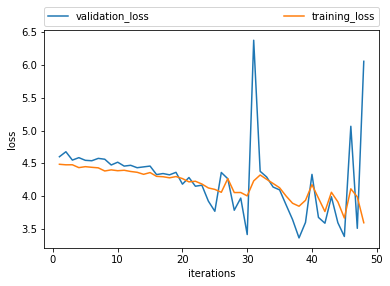

[4.5999084048801,
 4.676028587200023,
 4.548598889951353,
 4.585821946461995,
 4.5451850184687865,
 4.538723786671956,
 4.574978510538737,
 4.561817557723434,
 4.474079661899143,
 4.51650497648451,
 4.457128542440909,
 4.46924289950618,
 4.432317786746555,
 4.445013699708162,
 4.457504166497125,
 4.327634935025816,
 4.343279096815321,
 4.323952930944937,
 4.361775098023592,
 4.181502041993318,
 4.282738985838713,
 4.149892833497789,
 4.165714608298408,
 3.9226903032373497,
 3.7677304833023637,
 4.359659256758513,
 4.26415510530825,
 3.7835273566069425,
 3.9690858964566833,
 3.4128883768011025,
 6.3775570304305464,
 4.377544597343162,
 4.291079803749367,
 4.137438933054606,
 4.094376714141281,
 3.866289085812039,
 3.641467633070769,
 3.3611758903220847,
 3.597560167312622,
 4.330697342201516,
 3.674200941015173,
 3.585564622172603,
 3.989657031165229,
 3.592641238813047,
 3.3831356366475425,
 5.064687410990397,
 3.5075982764915183,
 6.056105843296757]

In [39]:
train_save('both', 2, 2)

minibatch:49, epoch:1, iteration:49, training_error:4.58464328289032, validation_error:5.363825692070855
Best loss improvement from inf to 5.363825692070855 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.679581923484802, validation_error:5.0232024899235475
Best loss improvement from 5.363825692070855 to 5.0232024899235475 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:4.658402910232544, validation_error:4.7011536492241754
Best loss improvement from 5.0232024899235475 to 4.7011536492241754 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:4.620958375930786, validation_error:4.741416048120569
minibatch:8, epoch:2, iteration:249, training_error:4.617316427230835, validation_error:4.7614324357774525
minibatch:58, epoch:2, iteration:299, training_error:4.6162098693847655, validation_error:4.7662101674962924
minibatch:108, epoch:2, iteration:349, training_error:4.59574764251709, validation_error:4.690773769661233
Best loss improvement from 4

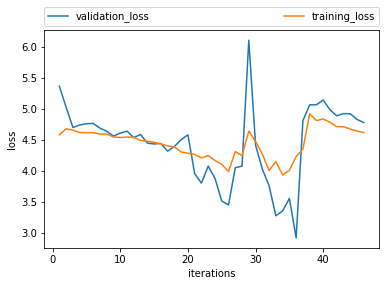

[5.363825692070855,
 5.0232024899235475,
 4.7011536492241754,
 4.741416048120569,
 4.7614324357774525,
 4.7662101674962924,
 4.690773769661233,
 4.6402181696008755,
 4.562486365989402,
 4.6118697766904475,
 4.641240738056324,
 4.538670539855957,
 4.588452445136176,
 4.450099609516285,
 4.435766025825783,
 4.4437255859375,
 4.320052570766872,
 4.395159014949092,
 4.505296247976798,
 4.583229771366826,
 3.958208675737734,
 3.806071546342638,
 4.080456424642493,
 3.882611124603837,
 3.519684906359072,
 3.4552440113491483,
 4.053601582845052,
 4.080852120010941,
 6.10391198264228,
 4.4179041827166525,
 4.031823688083225,
 3.7631405812722667,
 3.281395338199757,
 3.3587020768059626,
 3.5605808628929987,
 2.9252710783923113,
 4.811050044165717,
 5.064522213406033,
 5.066660351223415,
 5.14245930424443,
 4.986034075419108,
 4.888581099333586,
 4.923846774631077,
 4.921925562399405,
 4.830791226139775,
 4.780332812556514]

In [40]:
train_save('both', 3, 2)

minibatch:49, epoch:1, iteration:49, training_error:4.455563745498657, validation_error:4.985472605778621
Best loss improvement from inf to 4.985472605778621 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.4096014165878294, validation_error:4.489596348542434
Best loss improvement from 4.985472605778621 to 4.489596348542434 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:4.363428611755371, validation_error:4.463750747533945
Best loss improvement from 4.489596348542434 to 4.463750747533945 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:4.324371128082276, validation_error:4.430883976129385
Best loss improvement from 4.463750747533945 to 4.430883976129385 in epoch 1
minibatch:17, epoch:2, iteration:249, training_error:4.311831998825073, validation_error:4.473361492156982
minibatch:67, epoch:2, iteration:299, training_error:4.317332348823547, validation_error:4.445071605535654
minibatch:117, epoch:2, iteration:349, training_error:4.2774093

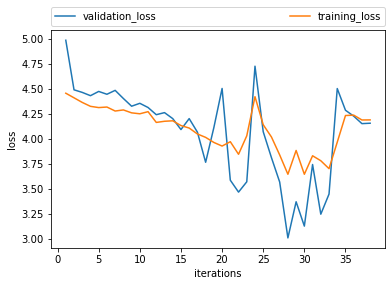

[4.985472605778621,
 4.489596348542434,
 4.463750747533945,
 4.430883976129385,
 4.473361492156982,
 4.445071605535654,
 4.484135279288659,
 4.402792417086088,
 4.325519882715666,
 4.3546446195015545,
 4.312646269798279,
 4.240720537992624,
 4.261450831706707,
 4.201606539579538,
 4.091918917802664,
 4.201553610654978,
 4.066147464972276,
 3.7648023642026462,
 4.111948031645555,
 4.5031894353719855,
 3.585416133587177,
 3.466338029274574,
 3.569433175600492,
 4.7258422924922066,
 4.0702140514667215,
 3.8111045085466824,
 3.5673079857459435,
 3.0080486536026,
 3.3697717098089366,
 3.1261420249938965,
 3.7423827189665575,
 3.2454115794255185,
 3.4466304870752187,
 4.502139650858366,
 4.285038407032307,
 4.22609267784999,
 4.151306528311509,
 4.155430481984065]

In [41]:
train_save('both', 4, 2)

minibatch:49, epoch:1, iteration:49, training_error:4.066366953849792, validation_error:4.587414686496441
Best loss improvement from inf to 4.587414686496441 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.865514326095581, validation_error:3.9677803057890673
Best loss improvement from 4.587414686496441 to 3.9677803057890673 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:3.782684121131897, validation_error:3.7838209867477417
Best loss improvement from 3.9677803057890673 to 3.7838209867477417 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:3.748122205734253, validation_error:3.825216146615835
minibatch:12, epoch:2, iteration:249, training_error:3.717836813926697, validation_error:3.7839666604995728
minibatch:62, epoch:2, iteration:299, training_error:3.708425760269165, validation_error:3.828842438184298
minibatch:112, epoch:2, iteration:349, training_error:3.710470757484436, validation_error:3.798456989801847
minibatch:162, epoch:2, ite

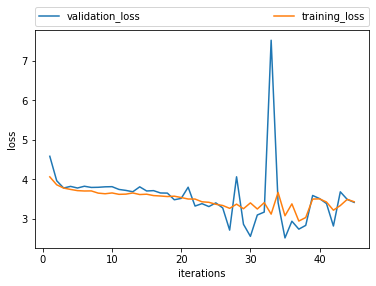

[4.587414686496441,
 3.9677803057890673,
 3.7838209867477417,
 3.825216146615835,
 3.7839666604995728,
 3.828842438184298,
 3.798456989801847,
 3.8021377875254703,
 3.8139778834122877,
 3.817849269280067,
 3.7478752503028283,
 3.72323045363793,
 3.6888016095528235,
 3.8136963110703688,
 3.7088030943503747,
 3.7175020346274743,
 3.6583251586327186,
 3.6546609860200148,
 3.4860247190182028,
 3.521483063697815,
 3.8041683985636783,
 3.3268469388668356,
 3.3880466864659238,
 3.3137055452053366,
 3.407032398077158,
 3.2791306605705848,
 2.7178181043038,
 4.067939501542312,
 2.865574222344619,
 2.559421814405001,
 3.1003228517679067,
 3.1747470727333655,
 7.525674086350661,
 3.4190234587742734,
 2.5202430486679077,
 2.943315469301664,
 2.7423125230349026,
 2.8376535268930287,
 3.594953857935392,
 3.5160886691166806,
 3.3897769084343543,
 2.8214104634064894,
 3.6874278508699856,
 3.4952935622288632,
 3.4200855310146627]

In [42]:
train_save('age', 0, 0)

minibatch:49, epoch:1, iteration:49, training_error:3.630520839691162, validation_error:3.4384741947568696
Best loss improvement from inf to 3.4384741947568696 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.0807846927642824, validation_error:3.1904933863672715
Best loss improvement from 3.4384741947568696 to 3.1904933863672715 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:3.083970832824707, validation_error:3.140325866896531
Best loss improvement from 3.1904933863672715 to 3.140325866896531 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:3.0216868829727175, validation_error:3.108865195307238
Best loss improvement from 3.140325866896531 to 3.108865195307238 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:2.9488889026641845, validation_error:3.1702334140909127
minibatch:41, epoch:2, iteration:299, training_error:2.9666274785995483, validation_error:3.046551983931969
Best loss improvement from 3.108865195307238 to 3.04

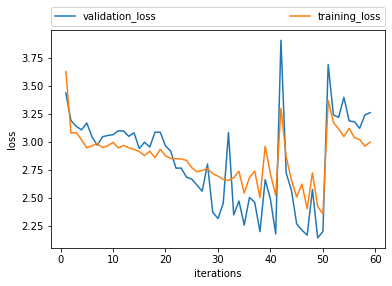

[3.4384741947568696,
 3.1904933863672715,
 3.140325866896531,
 3.108865195307238,
 3.1702334140909127,
 3.046551983931969,
 2.971604824066162,
 3.0473520837981125,
 3.059119800041462,
 3.0660257997183966,
 3.101496663586847,
 3.0993992460185082,
 3.051304217042594,
 3.082844413560012,
 2.9431719533328353,
 2.998662282680643,
 2.956059061247727,
 3.0879267988533807,
 3.087964345668924,
 2.9665645319840004,
 2.9185838041634393,
 2.767355696908359,
 2.767745149546656,
 2.686747435865731,
 2.668990332504799,
 2.6163036083352975,
 2.5621660660053123,
 2.803912138116771,
 2.374120021688527,
 2.317980038708654,
 2.4527787175671807,
 3.085238374512771,
 2.3502222546215714,
 2.4734323271389664,
 2.2586511866799714,
 2.506250792536242,
 2.462799836849344,
 2.2007375256768587,
 2.6651838483481574,
 2.4893712051983536,
 2.1799462622609633,
 3.9091530092831315,
 2.723666626831581,
 2.5686049461364746,
 2.2692441940307617,
 2.21339736724722,
 2.169794871889312,
 2.576882214381777,
 2.144530477194950

In [43]:
train_save('age', 1, 0)

minibatch:49, epoch:1, iteration:49, training_error:3.9641003084182738, validation_error:3.968508794389922
Best loss improvement from inf to 3.968508794389922 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.57953417301178, validation_error:3.546381448877269
Best loss improvement from 3.968508794389922 to 3.546381448877269 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:3.5456366395950316, validation_error:3.580596216793718
minibatch:199, epoch:1, iteration:199, training_error:3.489056944847107, validation_error:3.5660802331464043
minibatch:249, epoch:1, iteration:249, training_error:3.4673294162750246, validation_error:3.609708613362806
minibatch:45, epoch:2, iteration:299, training_error:3.4568333292007445, validation_error:3.6591210776361924
minibatch:95, epoch:2, iteration:349, training_error:3.462994627952576, validation_error:3.5059378887044974
Best loss improvement from 3.546381448877269 to 3.5059378887044974 in epoch 2
minibatch:145, epoch:2, it

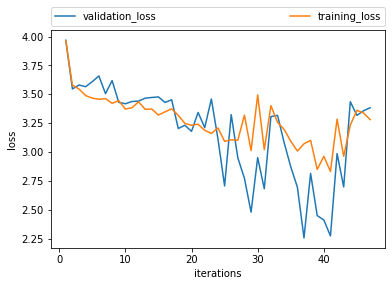

[3.968508794389922,
 3.546381448877269,
 3.580596216793718,
 3.5660802331464043,
 3.609708613362806,
 3.6591210776361924,
 3.5059378887044974,
 3.6191951981906234,
 3.4305159634557265,
 3.418135379922801,
 3.437826469026763,
 3.4411700840654045,
 3.4665500048933358,
 3.472628650994136,
 3.4775427949839623,
 3.4293918116339324,
 3.453024222933013,
 3.20371177278716,
 3.2319650074531294,
 3.17925841232826,
 3.3428576403650743,
 3.2113218307495117,
 3.4596014516106965,
 3.112458845664715,
 2.70636563465513,
 3.3239303046259385,
 2.9501296322921227,
 2.7720306166287125,
 2.478898582787349,
 2.952010212273433,
 2.6814051414358206,
 3.307095609862229,
 3.3181754802835397,
 3.0817443420147073,
 2.8722528260329674,
 2.695653397461464,
 2.2560024179261307,
 2.8144882218591096,
 2.4493092175187736,
 2.411095043708538,
 2.273331576380236,
 2.987076833330352,
 2.6976904951292893,
 3.4362636927900643,
 3.317268462016665,
 3.357871861293398,
 3.3837093155959557]

In [44]:
train_save('age', 2, 0)

minibatch:49, epoch:1, iteration:49, training_error:4.213874702453613, validation_error:4.425463994344075
Best loss improvement from inf to 4.425463994344075 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.045277953147888, validation_error:4.197007338205974
Best loss improvement from 4.425463994344075 to 4.197007338205974 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:3.999620885848999, validation_error:4.030277506510417
Best loss improvement from 4.197007338205974 to 4.030277506510417 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:3.96645779132843, validation_error:4.072550900777181
minibatch:249, epoch:1, iteration:249, training_error:3.9684550762176514, validation_error:4.059766030311584
minibatch:39, epoch:2, iteration:299, training_error:3.9424293422698975, validation_error:3.992022816340129
Best loss improvement from 4.030277506510417 to 3.992022816340129 in epoch 2
minibatch:89, epoch:2, iteration:349, training_error:3.9257930

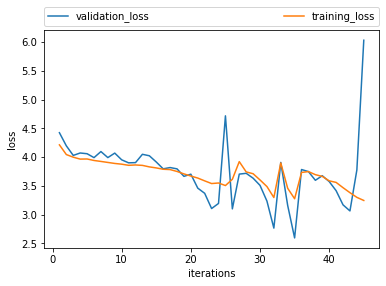

[4.425463994344075,
 4.197007338205974,
 4.030277506510417,
 4.072550900777181,
 4.059766030311584,
 3.992022816340129,
 4.097561232248942,
 3.9925511916478476,
 4.070647668838501,
 3.9539985338846844,
 3.9014067967732746,
 3.9052048683166505,
 4.049743207295736,
 4.024334104855855,
 3.915925145149231,
 3.7971718470255533,
 3.819175108273824,
 3.7966943979263306,
 3.66621732711792,
 3.703971203168233,
 3.461301803588867,
 3.3712610085805257,
 3.1065622568130493,
 3.195177515347799,
 4.718918800354004,
 3.10050683816274,
 3.705400808652242,
 3.7191519180933637,
 3.6344146887461344,
 3.5092352549235026,
 3.2360270420710244,
 2.7660709937413532,
 3.9087238868077594,
 3.159640073776245,
 2.5955985307693483,
 3.785129515329997,
 3.7490279197692873,
 3.5978338718414307,
 3.6771696249643964,
 3.575624402364095,
 3.4172032435735065,
 3.17072389125824,
 3.0648565610249836,
 3.7776367743810018,
 6.033490626017253]

In [45]:
train_save('age', 3, 0)

minibatch:49, epoch:1, iteration:49, training_error:4.261192750930786, validation_error:4.3513089418411255
Best loss improvement from inf to 4.3513089418411255 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.061268067359924, validation_error:4.031452017171042
Best loss improvement from 4.3513089418411255 to 4.031452017171042 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:3.9870673990249634, validation_error:4.1760318619864325
minibatch:199, epoch:1, iteration:199, training_error:3.9823842000961305, validation_error:4.08014007977077
minibatch:1, epoch:2, iteration:249, training_error:3.9450002765655516, validation_error:4.17302222762789
minibatch:51, epoch:2, iteration:299, training_error:3.9333404111862182, validation_error:4.085685525621686
minibatch:101, epoch:2, iteration:349, training_error:3.9216481828689576, validation_error:3.976876974105835
Best loss improvement from 4.031452017171042 to 3.976876974105835 in epoch 2
minibatch:151, epoch:2, ite

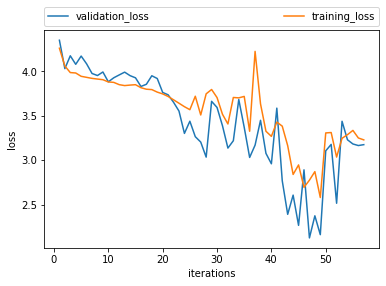

[4.3513089418411255,
 4.031452017171042,
 4.1760318619864325,
 4.08014007977077,
 4.17302222762789,
 4.085685525621686,
 3.976876974105835,
 3.953782158238547,
 3.9936247978891646,
 3.8828403183392117,
 3.928401563848768,
 3.9605182153838023,
 3.9919078605515614,
 3.9524803331920078,
 3.9279173612594604,
 3.830664191927229,
 3.8552351764270236,
 3.9512364098003934,
 3.920116526739938,
 3.7635511585644315,
 3.7363887429237366,
 3.652399488857814,
 3.55334849017007,
 3.3017271671976363,
 3.4390223026275635,
 3.2646880575588773,
 3.2039902295385088,
 3.0345453790255954,
 3.6630552666527882,
 3.5942043406622752,
 3.388313123158046,
 3.136358542101724,
 3.219308989388602,
 3.6835496851376126,
 3.3706007259232655,
 3.030910176890237,
 3.1694808517183577,
 3.4490920390401567,
 3.076782839638846,
 2.95938663823264,
 3.586361757346562,
 2.7677420718329295,
 2.3900354717459,
 2.606459770883833,
 2.2657741563660756,
 2.8911835806710378,
 2.124268902199609,
 2.3734661511012485,
 2.160844079085759,

In [46]:
train_save('age', 4, 0)

minibatch:49, epoch:1, iteration:49, training_error:4.21758038520813, validation_error:4.156226644149194
Best loss improvement from inf to 4.156226644149194 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.8558198976516724, validation_error:4.007838350075942
Best loss improvement from 4.156226644149194 to 4.007838350075942 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:3.818818311691284, validation_error:3.904704579940209
Best loss improvement from 4.007838350075942 to 3.904704579940209 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:3.788096966743469, validation_error:3.8963838265492368
Best loss improvement from 3.904704579940209 to 3.8963838265492368 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:3.738952283859253, validation_error:3.8864656686782837
Best loss improvement from 3.8963838265492368 to 3.8864656686782837 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:3.772717237472534, validation_error:

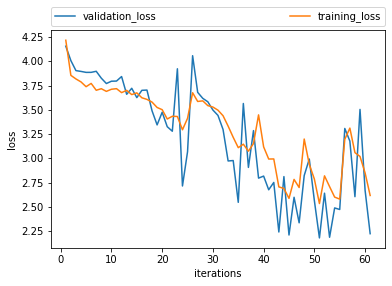

[4.156226644149194,
 4.007838350075942,
 3.904704579940209,
 3.8963838265492368,
 3.8864656686782837,
 3.8866712955328135,
 3.897712524120624,
 3.8267501409237203,
 3.771694935285128,
 3.7953557326243472,
 3.7970117972447324,
 3.8435193667045007,
 3.6605014984424296,
 3.7225726200984073,
 3.6262873044380775,
 3.7017468947630663,
 3.70415774675516,
 3.49070143699646,
 3.3452823345477762,
 3.475647311944228,
 3.326591757627634,
 3.280189266571632,
 3.9235910727427554,
 2.7158506375092726,
 3.0682971752606907,
 4.0582761122630195,
 3.680724859237671,
 3.6190516031705418,
 3.5833791127571692,
 3.498496046433082,
 3.4430408569482656,
 3.2980891924638014,
 2.97361474770766,
 2.977871848986699,
 2.5473511860920834,
 3.5657576505954447,
 2.9072224543644833,
 3.28650085742657,
 2.7967861799093394,
 2.817751022485586,
 2.6769101803119364,
 2.7523305232708273,
 2.2417206855920644,
 2.812559256186852,
 2.210683918916262,
 2.5995642772087684,
 2.3363809952369103,
 2.823427044428312,
 2.993593078393

In [47]:
train_save('age', 0, 1)

minibatch:49, epoch:1, iteration:49, training_error:4.043721690177917, validation_error:4.394746517312938
Best loss improvement from inf to 4.394746517312938 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.821746597290039, validation_error:3.7525582971244025
Best loss improvement from 4.394746517312938 to 3.7525582971244025 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:3.722842698097229, validation_error:3.7489001422092834
Best loss improvement from 3.7525582971244025 to 3.7489001422092834 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:3.7113241004943847, validation_error:3.739362190509665
Best loss improvement from 3.7489001422092834 to 3.739362190509665 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:3.7046338176727294, validation_error:3.7641941432295174
minibatch:41, epoch:2, iteration:299, training_error:3.6739463424682617, validation_error:3.716277270481504
Best loss improvement from 3.739362190509665 to 3.716

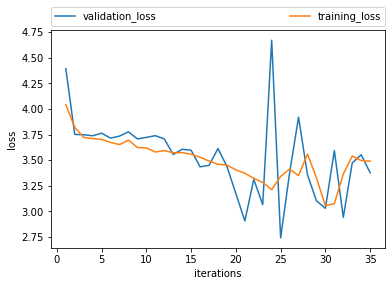

[4.394746517312938,
 3.7525582971244025,
 3.7489001422092834,
 3.739362190509665,
 3.7641941432295174,
 3.716277270481504,
 3.7358640555677742,
 3.7774383528479216,
 3.7081520228550353,
 3.72332344384029,
 3.740098780599134,
 3.708708072530812,
 3.55673361646718,
 3.6073541476808746,
 3.597882895634092,
 3.43618210430803,
 3.4501325508643843,
 3.6146201429695917,
 3.4394607872798524,
 3.1751393531930856,
 2.9079936455036033,
 3.312932589958454,
 3.067091678750926,
 4.671502705278067,
 2.742120126198078,
 3.3756935925319276,
 3.920479388072573,
 3.3579640552915375,
 3.1040602141413194,
 3.0309282829021584,
 3.594451879632884,
 2.9430474577278924,
 3.4747536757896684,
 3.553852212840113,
 3.3777532248661437]

In [48]:
train_save('age', 1, 1)

minibatch:49, epoch:1, iteration:49, training_error:4.22273895740509, validation_error:4.581498590008966
Best loss improvement from inf to 4.581498590008966 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:4.054092559814453, validation_error:4.112282974966641
Best loss improvement from 4.581498590008966 to 4.112282974966641 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:3.9802263498306276, validation_error:4.095433909317543
Best loss improvement from 4.112282974966641 to 4.095433909317543 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:3.9700711584091186, validation_error:4.140768527984619
minibatch:249, epoch:1, iteration:249, training_error:3.9447493982315063, validation_error:4.211661996512578
minibatch:45, epoch:2, iteration:299, training_error:3.9324203014373778, validation_error:4.05935838304717
Best loss improvement from 4.095433909317543 to 4.05935838304717 in epoch 2
minibatch:95, epoch:2, iteration:349, training_error:3.9042448

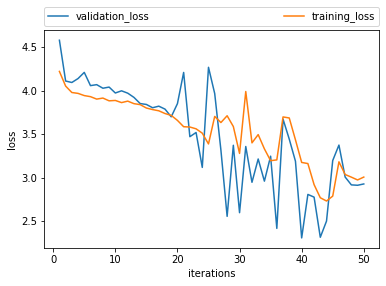

[4.581498590008966,
 4.112282974966641,
 4.095433909317543,
 4.140768527984619,
 4.211661996512578,
 4.05935838304717,
 4.07046521943191,
 4.029360549203281,
 4.0425162973075075,
 3.974613978944976,
 3.9995673607135642,
 3.9725107324534448,
 3.9238376699644943,
 3.852962954290982,
 3.8427156333265633,
 3.804884877698175,
 3.8229215391750992,
 3.78895745606258,
 3.700283930219453,
 3.852073151489784,
 4.210965378531094,
 3.471668374949488,
 3.5199251914846488,
 3.1183044581577697,
 4.270159556947905,
 3.968067193853444,
 3.31634574923022,
 2.555181519738559,
 3.372884018667813,
 2.5974142469208816,
 3.3589279980495057,
 2.947114952679338,
 3.2151140015700768,
 2.9602501803431016,
 3.247559736514914,
 2.416712834917266,
 3.673767566680908,
 3.444196651721823,
 3.189564852878965,
 2.3070530562565246,
 2.807454799783641,
 2.77629252959942,
 2.3145749240085998,
 2.500577014068077,
 3.197801507752517,
 3.375185415662568,
 3.007462978363037,
 2.917283847414214,
 2.9128417475470183,
 2.9279731

In [49]:
train_save('age', 2, 1)

minibatch:49, epoch:1, iteration:49, training_error:3.9465315914154053, validation_error:4.246170234680176
Best loss improvement from inf to 4.246170234680176 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.6587587070465086, validation_error:3.5354490518569945
Best loss improvement from 4.246170234680176 to 3.5354490518569945 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:3.521555633544922, validation_error:3.509710439046224
Best loss improvement from 3.5354490518569945 to 3.509710439046224 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:3.5620266914367678, validation_error:3.5980281829833984
minibatch:249, epoch:1, iteration:249, training_error:3.479830513000488, validation_error:3.646254221598307
minibatch:39, epoch:2, iteration:299, training_error:3.456376438140869, validation_error:3.5887370824813845
minibatch:89, epoch:2, iteration:349, training_error:3.482435212135315, validation_error:3.548851188023885
minibatch:139, epoch:2, i

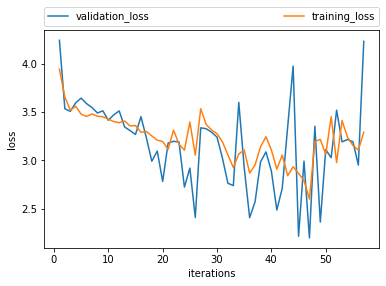

[4.246170234680176,
 3.5354490518569945,
 3.509710439046224,
 3.5980281829833984,
 3.646254221598307,
 3.5887370824813845,
 3.548851188023885,
 3.492280133565267,
 3.514416726430257,
 3.41680695215861,
 3.473418196042379,
 3.5139010588328046,
 3.34718755086263,
 3.309622589747111,
 3.2697578112284345,
 3.453755235671997,
 3.235106666882833,
 2.992428119977315,
 3.0971972227096556,
 2.7826167821884153,
 3.1812604586283366,
 3.1986982107162474,
 3.1919623454411825,
 2.7243918657302855,
 2.9210455814997354,
 2.4090643246968586,
 3.338615043958028,
 3.329109311103821,
 3.2928872108459473,
 3.2423036336898803,
 3.0226001739501953,
 2.763962272802989,
 2.740031425158183,
 3.601867659886678,
 2.9269521395365397,
 2.4069761355717976,
 2.572816530863444,
 2.9846275885899862,
 3.088863507906596,
 2.889446767171224,
 2.4869299014409383,
 2.7118913491566974,
 3.3498794078826903,
 3.9778977076212567,
 2.215197038650513,
 2.993777330716451,
 2.197559150060018,
 3.3548481305440268,
 2.361289159456888

In [50]:
train_save('age', 3, 1)

minibatch:49, epoch:1, iteration:49, training_error:3.8638349962234497, validation_error:4.153099298477173
Best loss improvement from inf to 4.153099298477173 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.4641380500793457, validation_error:3.6550922223499844
Best loss improvement from 4.153099298477173 to 3.6550922223499844 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:3.4576187801361082, validation_error:3.5425388046673367
Best loss improvement from 3.6550922223499844 to 3.5425388046673367 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:3.3928794479370117, validation_error:3.5654892921447754
minibatch:1, epoch:2, iteration:249, training_error:3.389247388839722, validation_error:3.4878781693322316
Best loss improvement from 3.5425388046673367 to 3.4878781693322316 in epoch 2
minibatch:51, epoch:2, iteration:299, training_error:3.396663112640381, validation_error:3.5570854118892123
minibatch:101, epoch:2, iteration:349, training_err

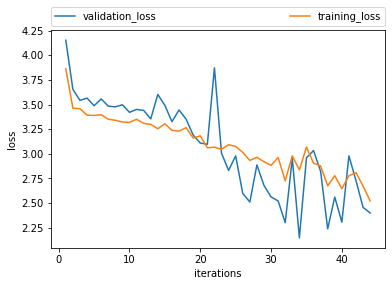

[4.153099298477173,
 3.6550922223499844,
 3.5425388046673367,
 3.5654892921447754,
 3.4878781693322316,
 3.5570854118892123,
 3.4838314056396484,
 3.4766633340290616,
 3.4977283818381175,
 3.4210432256971086,
 3.4506315418652127,
 3.440991589001247,
 3.3543266483715604,
 3.6030340365001132,
 3.4914354937417165,
 3.326475441455841,
 3.445248067378998,
 3.3513902681214467,
 3.1900144730295454,
 3.1092629432678223,
 3.096482183252062,
 3.8727567536490306,
 3.0052695529801503,
 2.8317605682781766,
 2.9792431678090776,
 2.5974316767283847,
 2.5105729358536855,
 2.887442639895848,
 2.679147941725595,
 2.562150537967682,
 2.5213002477373396,
 2.3012043237686157,
 2.9539174011775424,
 2.145904093980789,
 2.9587495837892805,
 3.033326472554888,
 2.8216391035488675,
 2.237832656928471,
 2.560845579419817,
 2.30585834809712,
 2.978949555328914,
 2.72764390707016,
 2.4553879584584917,
 2.399378716945648]

In [51]:
train_save('age', 4, 1)

In [ ]:
train_save('age', 0, 2)

minibatch:49, epoch:1, iteration:49, training_error:4.016572942733765, validation_error:4.077531362402028
Best loss improvement from inf to 4.077531362402028 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.52021586894989, validation_error:3.56874549799952
Best loss improvement from 4.077531362402028 to 3.56874549799952 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:3.4444976902008055, validation_error:3.636208616454026
minibatch:199, epoch:1, iteration:199, training_error:3.471871519088745, validation_error:3.575817889180677
minibatch:249, epoch:1, iteration:249, training_error:3.423367199897766, validation_error:3.5338962489160997
Best loss improvement from 3.56874549799952 to 3.5338962489160997 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:3.4178732347488405, validation_error:3.477247616340374
Best loss improvement from 3.5338962489160997 to 3.477247616340374 in epoch 2
minibatch:91, epoch:2, iteration:349, training_error:3.3877504

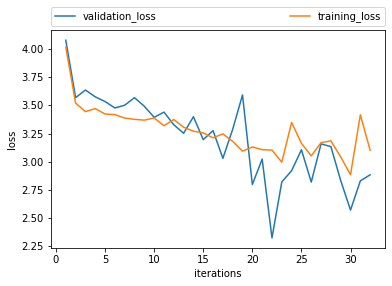

[4.077531362402028,
 3.56874549799952,
 3.636208616454026,
 3.575817889180677,
 3.5338962489160997,
 3.477247616340374,
 3.5015258706849197,
 3.568488910280425,
 3.491888769741716,
 3.3942377156224746,
 3.4405601600120805,
 3.328451575904057,
 3.252978226234173,
 3.399388806573276,
 3.196634596791761,
 3.2759464526998587,
 3.0306640822311928,
 3.288464431104989,
 3.5927553752373003,
 2.7981676233225854,
 3.023899958051484,
 2.325023338712495,
 2.821119966178105,
 2.920844859090345,
 3.1064500315436003,
 2.820187075384732,
 3.158665558387493,
 3.1346291098101386,
 2.8336876754103035,
 2.5716826833527664,
 2.830679071360621,
 2.884648684797616]

In [53]:
train_save('age', 1, 2)

In [ ]:
train_save('age', 2, 2)

minibatch:49, epoch:1, iteration:49, training_error:3.8889992952346804, validation_error:4.136380060513814
Best loss improvement from inf to 4.136380060513814 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.567360129356384, validation_error:3.5618654092152915
Best loss improvement from 4.136380060513814 to 3.5618654092152915 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:3.529621205329895, validation_error:3.5925313393274942
minibatch:199, epoch:1, iteration:199, training_error:3.4930008602142335, validation_error:3.484670106569926
Best loss improvement from 3.5618654092152915 to 3.484670106569926 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:3.479203391075134, validation_error:3.538235815366109
minibatch:39, epoch:2, iteration:299, training_error:3.4462007093429565, validation_error:3.55775412718455
minibatch:89, epoch:2, iteration:349, training_error:3.457417006492615, validation_error:3.433794546127319
Best loss improvement from 

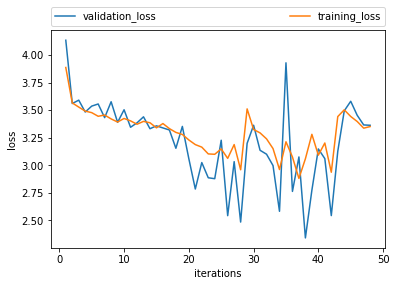

[4.136380060513814,
 3.5618654092152915,
 3.5925313393274942,
 3.484670106569926,
 3.538235815366109,
 3.55775412718455,
 3.433794546127319,
 3.5781004269917807,
 3.3912967284520468,
 3.5053196986516317,
 3.3465197642644244,
 3.3866366863250734,
 3.4411779403686524,
 3.3331926663716636,
 3.35937184492747,
 3.340357605616252,
 3.3216906070709227,
 3.155692156155904,
 3.354097596804301,
 3.0611884435017904,
 2.7857062896092732,
 3.025924030939738,
 2.8879124879837037,
 2.8794819275538126,
 3.228598721822103,
 2.543819204966227,
 3.0342228253682455,
 2.485754060745239,
 3.2003482580184937,
 3.3647658586502076,
 3.137379511197408,
 3.1017657121022544,
 2.998669489224752,
 2.583467173576355,
 3.9314419507980345,
 2.764015245437622,
 3.077011545499166,
 2.341879630088806,
 2.77457218170166,
 3.1496317942937213,
 3.0617520093917845,
 2.544565757115682,
 3.1282065788904827,
 3.495564921696981,
 3.5823668082555136,
 3.455036497116089,
 3.3675973892211912,
 3.3644333680470786]

In [55]:
train_save('age', 3, 2)

In [ ]:
train_save('age', 4, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.300877915620804, validation_error:1.8156919611824884
Best loss improvement from inf to 1.8156919611824884 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.4668102264404297, validation_error:1.3522278997633193
Best loss improvement from 1.8156919611824884 to 1.3522278997633193 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.3486788856983185, validation_error:1.445352624963831
minibatch:199, epoch:1, iteration:199, training_error:1.303224309682846, validation_error:1.3164527040940743
Best loss improvement from 1.3522278997633193 to 1.3164527040940743 in epoch 1
minibatch:3, epoch:2, iteration:249, training_error:1.3290274250507355, validation_error:1.3346197251920346
minibatch:53, epoch:2, iteration:299, training_error:1.3300371623039247, validation_error:1.2806733934967607
Best loss improvement from 1.3164527040940743 to 1.2806733934967607 in epoch 2
minibatch:103, epoch:2, iteration:349, training_e

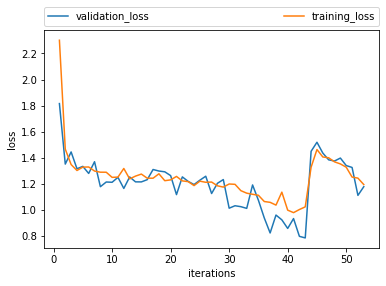

[1.8156919611824884,
 1.3522278997633193,
 1.445352624963831,
 1.3164527040940743,
 1.3346197251920346,
 1.2806733934967607,
 1.3703912408263594,
 1.179069870048099,
 1.2149837127438299,
 1.2129358207737957,
 1.2507367774292275,
 1.1657798952526517,
 1.2536117522804826,
 1.2161559926138983,
 1.2157805893156264,
 1.2328797159371552,
 1.3107777657332245,
 1.2990773474728619,
 1.293087080672935,
 1.2640176349216037,
 1.1184172321248937,
 1.2541874823746857,
 1.2194903492927551,
 1.1954282036534063,
 1.2289501825968425,
 1.2592459541779977,
 1.126758266378332,
 1.2050701092790674,
 1.233689217655747,
 1.0144095641595345,
 1.0331233099654868,
 1.02600277794732,
 1.01300358110004,
 1.1925380649390045,
 1.0748823704542938,
 0.9397891737796642,
 0.8246345630398503,
 0.9617630773120456,
 0.9252371589342753,
 0.8594176945862947,
 0.9348979261186388,
 0.798787514368693,
 0.7867203266532333,
 1.4501660135057237,
 1.519502341747284,
 1.4367664478443287,
 1.3848463738406147,
 1.375711723610207,
 1.3

In [57]:
train_save('gender', 0, 0)

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


minibatch:49, epoch:1, iteration:49, training_error:3.208492469787598, validation_error:3.4900035529301086
Best loss improvement from inf to 3.4900035529301086 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.8144462299346924, validation_error:2.854385367755232
Best loss improvement from 3.4900035529301086 to 2.854385367755232 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.7428988361358644, validation_error:2.8067967151773385
Best loss improvement from 2.854385367755232 to 2.8067967151773385 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.7073064661026, validation_error:2.793491848583879
Best loss improvement from 2.8067967151773385 to 2.793491848583879 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:2.6807636547088625, validation_error:2.703954737761925
Best loss improvement from 2.793491848583879 to 2.703954737761925 in epoch 1
minibatch:47, epoch:2, iteration:299, training_error:2.6635474443435667, validation_er

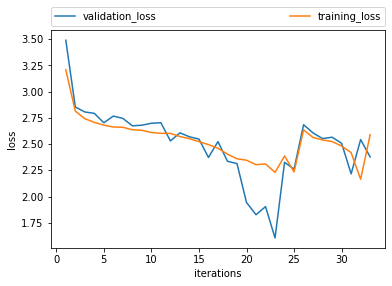

[3.4900035529301086,
 2.854385367755232,
 2.8067967151773385,
 2.793491848583879,
 2.703954737761925,
 2.767559585900142,
 2.7453746384587783,
 2.674688298126747,
 2.6805420004088303,
 2.6994155439837226,
 2.704011892450267,
 2.530807347133242,
 2.6077667762493264,
 2.57028970225104,
 2.548495884599357,
 2.373241588987153,
 2.5245330251496414,
 2.3364286258302887,
 2.3150336002481393,
 1.9444673554650669,
 1.8280176828647483,
 1.9050758378259067,
 1.6068293555029507,
 2.326687763477194,
 2.262791814475224,
 2.685269437987229,
 2.6067588329315186,
 2.5531003064122695,
 2.5660632889846275,
 2.508205093186477,
 2.217318090899237,
 2.543670818723481,
 2.3776909647316766]

In [35]:
train_save('gender', 1, 0)

In [ ]:
train_save('gender', 2, 0)

minibatch:49, epoch:1, iteration:49, training_error:3.3476188516616823, validation_error:3.499435515239321
Best loss improvement from inf to 3.499435515239321 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.806732664108276, validation_error:2.8738538396769555
Best loss improvement from 3.499435515239321 to 2.8738538396769555 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.7570715665817263, validation_error:2.854527736532277
Best loss improvement from 2.8738538396769555 to 2.854527736532277 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.710653681755066, validation_error:2.7713935375213623
Best loss improvement from 2.854527736532277 to 2.7713935375213623 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:2.6862726163864137, validation_error:2.801756028471322
minibatch:39, epoch:2, iteration:299, training_error:2.6841201972961426, validation_error:2.739343018367373
Best loss improvement from 2.7713935375213623 to 2.739

minibatch:49, epoch:1, iteration:49, training_error:3.3622361326217653, validation_error:3.3590968395101615
Best loss improvement from inf to 3.3590968395101615 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.820998969078064, validation_error:2.86793355284066
Best loss improvement from 3.3590968395101615 to 2.86793355284066 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.7590507793426515, validation_error:2.8279654486425994
Best loss improvement from 2.86793355284066 to 2.8279654486425994 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.7107143354415895, validation_error:2.77390665021436
Best loss improvement from 2.8279654486425994 to 2.77390665021436 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:2.693282766342163, validation_error:2.756907685049649
Best loss improvement from 2.77390665021436 to 2.756907685049649 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:2.68212203502655, validation_error:2.

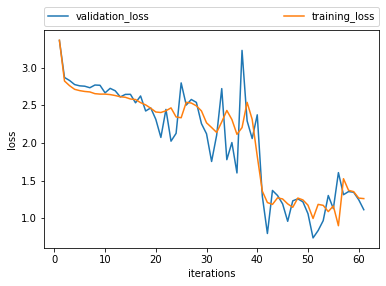

[3.3590968395101615,
 2.86793355284066,
 2.8279654486425994,
 2.77390665021436,
 2.756907685049649,
 2.752031054990045,
 2.731625926905665,
 2.7677472870925377,
 2.764420517559709,
 2.663860617012813,
 2.7235186922139136,
 2.6914616124383333,
 2.609816493659184,
 2.6432994480790764,
 2.6442741607797555,
 2.531795279733066,
 2.622251568169429,
 2.423042601552503,
 2.4640323375833444,
 2.3125376619141678,
 2.072190679352859,
 2.443788429786419,
 2.022469611003481,
 2.1261239586205316,
 2.7957648326610696,
 2.501874964812706,
 2.5759813456699767,
 2.537015906695662,
 2.255196842653998,
 2.120201378033079,
 1.752788079196009,
 2.10306232139982,
 2.720280984352375,
 1.7766532774629265,
 2.0039653860289475,
 1.6004447854798416,
 3.2273420794256804,
 2.292249794664054,
 2.0573479512642168,
 2.3721932419415177,
 1.2907613988580375,
 0.7967560928443382,
 1.3680603093114392,
 1.3007011043614354,
 1.1895549379546067,
 0.958356773031169,
 1.2300894794792965,
 1.2570957233165871,
 1.21682758783472,

In [60]:
train_save('gender', 3, 0)

minibatch:49, epoch:1, iteration:49, training_error:2.1720459127426146, validation_error:1.7390732559664497
Best loss improvement from inf to 1.7390732559664497 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.4716453766822815, validation_error:1.412781390650519
Best loss improvement from 1.7390732559664497 to 1.412781390650519 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.4005550622940064, validation_error:1.402307025317488
Best loss improvement from 1.412781390650519 to 1.402307025317488 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.3421824920177459, validation_error:1.3376521714802445
Best loss improvement from 1.402307025317488 to 1.3376521714802445 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.3486337757110596, validation_error:1.4521941748158684
minibatch:44, epoch:2, iteration:299, training_error:1.3449727082252503, validation_error:1.28665239646517
Best loss improvement from 1.3376521714802445 to 1.2

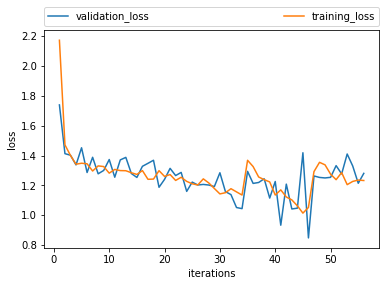

[1.7390732559664497,
 1.412781390650519,
 1.402307025317488,
 1.3376521714802445,
 1.4521941748158684,
 1.28665239646517,
 1.3885478870622043,
 1.2779258242968856,
 1.3003577261135495,
 1.373438863918699,
 1.255035034541426,
 1.3710329655943245,
 1.3878880615892082,
 1.2799080980235134,
 1.2535527122431789,
 1.3281096713296299,
 1.3481083060133046,
 1.3685446361015583,
 1.1877419640277993,
 1.2409084459830975,
 1.3143915307932887,
 1.2660983184288288,
 1.2872225354457725,
 1.1602435584726005,
 1.222330946346809,
 1.2029814247427315,
 1.2067740888431155,
 1.2026881719457692,
 1.192695950639659,
 1.2849476460752816,
 1.158520719100689,
 1.1385849960919083,
 1.0522044198266391,
 1.0446662841172054,
 1.2941589930961872,
 1.2136356008463893,
 1.2197296701628586,
 1.2444403233199284,
 1.1154208450481808,
 1.2262871285964703,
 0.9338064687005405,
 1.2087483488280197,
 1.0425387662032555,
 1.0478557430464646,
 1.4189136768209523,
 0.8487123826454426,
 1.2634729064744095,
 1.2536628883460472,
 

In [61]:
train_save('gender', 4, 0)

minibatch:49, epoch:1, iteration:49, training_error:3.297759871482849, validation_error:3.619336658053928
Best loss improvement from inf to 3.619336658053928 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.836252784729004, validation_error:2.84623024198744
Best loss improvement from 3.619336658053928 to 2.84623024198744 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.7372771310806274, validation_error:2.7706864763189247
Best loss improvement from 2.84623024198744 to 2.7706864763189247 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.7138950538635256, validation_error:2.816579580307007
minibatch:3, epoch:2, iteration:249, training_error:2.696788387298584, validation_error:2.757703842940154
Best loss improvement from 2.7706864763189247 to 2.757703842940154 in epoch 2
minibatch:53, epoch:2, iteration:299, training_error:2.668430118560791, validation_error:2.748468354896263
Best loss improvement from 2.757703842940154 to 2.7484683548962

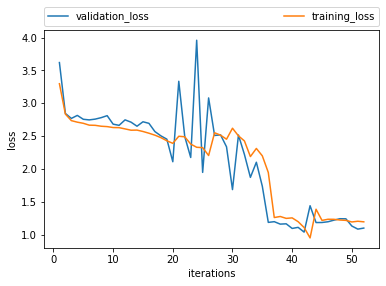

[3.619336658053928,
 2.84623024198744,
 2.7706864763189247,
 2.816579580307007,
 2.757703842940154,
 2.748468354896263,
 2.7603032235746032,
 2.78243186738756,
 2.812717005058571,
 2.683664224765919,
 2.665733893712362,
 2.7487295733557806,
 2.714026442280522,
 2.652291492179588,
 2.7198263627511485,
 2.696148907696759,
 2.5709157078354448,
 2.506136408558598,
 2.4556008533195213,
 2.1127290769859597,
 3.3350543710920544,
 2.495810173175953,
 2.177463928858439,
 3.9584450721740723,
 1.9507740824310869,
 3.0821632632502802,
 2.511898667724044,
 2.5210630098978677,
 2.3396446616561324,
 1.6895861184155498,
 2.518320163091024,
 2.2234737431561507,
 1.8752029957594696,
 2.105053663253784,
 1.7396639938707705,
 1.191397296057807,
 1.2021522367442097,
 1.16519621124974,
 1.1697580130011946,
 1.099559658103519,
 1.1157988707224529,
 1.0435531536738079,
 1.4446051010379084,
 1.188964828296944,
 1.189688786312386,
 1.2009001926139549,
 1.2253725418338068,
 1.2468677759170532,
 1.245870148694073

In [62]:
train_save('gender', 0, 1)

minibatch:49, epoch:1, iteration:49, training_error:3.3727820801734922, validation_error:3.515940682641391
Best loss improvement from inf to 3.515940682641391 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.8097040271759033, validation_error:2.9558499517111945
Best loss improvement from 3.515940682641391 to 2.9558499517111945 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.7336618804931643, validation_error:2.8596976050015153
Best loss improvement from 2.9558499517111945 to 2.8596976050015153 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.7105104112625122, validation_error:2.779013025349584
Best loss improvement from 2.8596976050015153 to 2.779013025349584 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:2.6954862880706787, validation_error:2.771692029361067
Best loss improvement from 2.779013025349584 to 2.771692029361067 in epoch 1
minibatch:47, epoch:2, iteration:299, training_error:2.677974524497986, validation

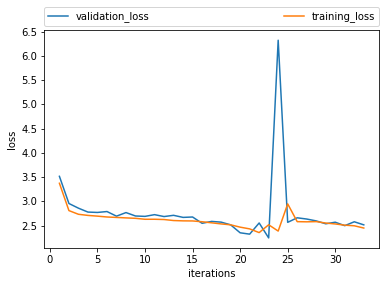

[3.515940682641391,
 2.9558499517111945,
 2.8596976050015153,
 2.779013025349584,
 2.771692029361067,
 2.790212762766871,
 2.694920638511921,
 2.7688982568938156,
 2.6983551321358514,
 2.6907456661092826,
 2.7259153744270064,
 2.6868396463065314,
 2.7123504342703986,
 2.6696444215445685,
 2.67757248878479,
 2.5477566390201964,
 2.586751946087541,
 2.57178179971103,
 2.516312812936717,
 2.352056758157138,
 2.3241222315821153,
 2.554472101145777,
 2.2464667517563393,
 6.321610976909769,
 2.567727261576159,
 2.66110111927164,
 2.6356270970969367,
 2.59708413584479,
 2.5378463186066726,
 2.5703348373544626,
 2.4988858370945373,
 2.5792373459914635,
 2.515756467293049]

In [63]:
train_save('gender', 1, 1)

minibatch:49, epoch:1, iteration:49, training_error:3.371143798828125, validation_error:3.286339726941339
Best loss improvement from inf to 3.286339726941339 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.7952360010147093, validation_error:2.8434205795156546
Best loss improvement from 3.286339726941339 to 2.8434205795156546 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.7407313871383665, validation_error:2.7431854297374856
Best loss improvement from 2.8434205795156546 to 2.7431854297374856 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.7223110389709473, validation_error:2.7364563941955566
Best loss improvement from 2.7431854297374856 to 2.7364563941955566 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:2.675063924789429, validation_error:2.776293228412497
minibatch:39, epoch:2, iteration:299, training_error:2.683068370819092, validation_error:2.7643825678989806
minibatch:89, epoch:2, iteration:349, training_erro

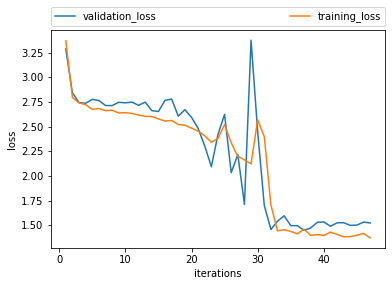

[3.286339726941339,
 2.8434205795156546,
 2.7431854297374856,
 2.7364563941955566,
 2.776293228412497,
 2.7643825678989806,
 2.71406417879565,
 2.712982251726348,
 2.746633093932579,
 2.740864161787362,
 2.74840261196268,
 2.715640059832869,
 2.748238908833471,
 2.6620154298585037,
 2.6531846934351426,
 2.7668564237397293,
 2.7792078544353616,
 2.6059617585149306,
 2.6712332840623527,
 2.5938331012068123,
 2.481517421788183,
 2.3042635177743844,
 2.093639636861867,
 2.420464310152777,
 2.6238751082584777,
 2.0328724425414513,
 2.2169574951303415,
 1.7107538354807887,
 3.3754789171547723,
 2.4483698236531226,
 1.70062622530707,
 1.4569269542036385,
 1.540579919157357,
 1.5960071909016575,
 1.4962461899066795,
 1.4955494979332233,
 1.4491582697835461,
 1.472044143183478,
 1.5292545310382186,
 1.533541909579573,
 1.489673678217263,
 1.5245532002942315,
 1.5260806700278973,
 1.4988548097939327,
 1.5014841967615589,
 1.531906954173384,
 1.5233197047792633]

In [64]:
train_save('gender', 2, 1)

minibatch:49, epoch:1, iteration:49, training_error:3.345028266906738, validation_error:3.410496407541735
Best loss improvement from inf to 3.410496407541735 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.787001724243164, validation_error:2.8187122427184006
Best loss improvement from 3.410496407541735 to 2.8187122427184006 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.7621637535095216, validation_error:2.780811671552987
Best loss improvement from 2.8187122427184006 to 2.780811671552987 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.7067012643814086, validation_error:2.825096631872243
minibatch:249, epoch:1, iteration:249, training_error:2.69811279296875, validation_error:2.799225355016774
minibatch:41, epoch:2, iteration:299, training_error:2.688230562210083, validation_error:2.7324376681755327
Best loss improvement from 2.780811671552987 to 2.7324376681755327 in epoch 2
minibatch:91, epoch:2, iteration:349, training_error:2.66

minibatch:219, epoch:11, iteration:2799, training_error:1.421508731842041, validation_error:1.4867104785195713
minibatch:11, epoch:12, iteration:2849, training_error:1.417771624326706, validation_error:1.5643360943629825
minibatch:61, epoch:12, iteration:2899, training_error:1.4352661228179933, validation_error:1.5406317176489994
Patience ran out at 2899. Ending training


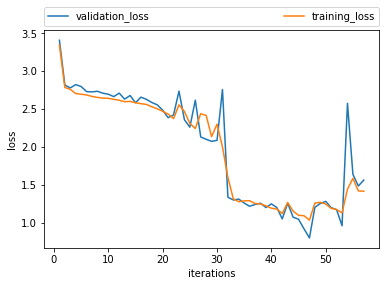

[3.410496407541735,
 2.8187122427184006,
 2.780811671552987,
 2.825096631872243,
 2.799225355016774,
 2.7324376681755327,
 2.7286709423722892,
 2.736853780417607,
 2.711416450040094,
 2.69770963438626,
 2.6667793619221656,
 2.712339228597181,
 2.6331206190175025,
 2.6809276219072014,
 2.584991019347618,
 2.659394354655825,
 2.6307998936751793,
 2.588671486953209,
 2.5580137433676886,
 2.4879177685441642,
 2.387897853193612,
 2.4248206862087907,
 2.738420774196756,
 2.361176778530252,
 2.2631411716855805,
 2.6195569778310843,
 2.1337507839860588,
 2.1029691778380295,
 2.0760185718536377,
 2.089161646777186,
 2.7604476007921943,
 1.3380561286005481,
 1.30218027583484,
 1.3136227213103195,
 1.2608459365778957,
 1.219186661572292,
 1.2429409088759586,
 1.2591786076282632,
 1.2020368123876637,
 1.2503803886216263,
 1.2018676235758026,
 1.0522367789827545,
 1.2591999193717693,
 1.0744366933559548,
 1.0475900275953884,
 0.9214254124411221,
 0.801172542160955,
 1.2052602007471283,
 1.255980958

In [65]:
train_save('gender', 3, 1)

minibatch:49, epoch:1, iteration:49, training_error:3.291237235069275, validation_error:3.547990634523589
Best loss improvement from inf to 3.547990634523589 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.8055969047546387, validation_error:2.9362183028254014
Best loss improvement from 3.547990634523589 to 2.9362183028254014 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.7458060026168822, validation_error:2.7784445943503546
Best loss improvement from 2.9362183028254014 to 2.7784445943503546 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.703465671539307, validation_error:2.773491308606904
Best loss improvement from 2.7784445943503546 to 2.773491308606904 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:2.676924047470093, validation_error:2.6965528685471107
Best loss improvement from 2.773491308606904 to 2.6965528685471107 in epoch 1
minibatch:44, epoch:2, iteration:299, training_error:2.6641965103149414, validation

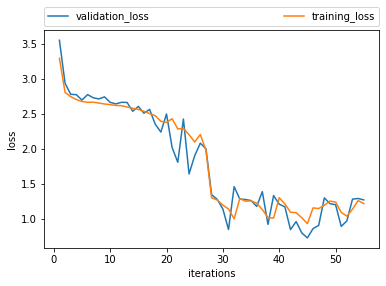

[3.547990634523589,
 2.9362183028254014,
 2.7784445943503546,
 2.773491308606904,
 2.6965528685471107,
 2.7739008295124976,
 2.728881942814794,
 2.71249141364262,
 2.741613346954872,
 2.6644006433158087,
 2.6414718299076476,
 2.6643152894644904,
 2.6627542972564697,
 2.5371093092293573,
 2.606039968030206,
 2.509685573906734,
 2.5633833819422227,
 2.3533585975910056,
 2.2406996776317727,
 2.498376624337558,
 2.0194560042743026,
 1.811026141561311,
 2.426375076688569,
 1.6451530908716137,
 1.9042116280259758,
 2.0829705739843436,
 2.0027656144109267,
 1.3497036880460278,
 1.2831052562286114,
 1.145333853261224,
 0.8537752772199696,
 1.464112361957287,
 1.2874263463349178,
 1.2811111314543362,
 1.265983141701797,
 1.1824714767521824,
 1.392315934444296,
 0.9265822521571455,
 1.337103009223938,
 1.213990920576556,
 1.1766932688910385,
 0.8527012076871149,
 0.9667224287986755,
 0.8046705250082344,
 0.7341529850302071,
 0.8670295908533293,
 0.9124455287538725,
 1.3040517219181718,
 1.222221

In [66]:
train_save('gender', 4, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.1969939529895783, validation_error:1.2324675144972626
Best loss improvement from inf to 1.2324675144972626 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.634727761745453, validation_error:1.5597098624264751
minibatch:149, epoch:1, iteration:149, training_error:1.4828818392753602, validation_error:1.557412487489206
minibatch:199, epoch:1, iteration:199, training_error:1.468500123023987, validation_error:1.5745659316027607
minibatch:3, epoch:2, iteration:249, training_error:1.4646458756923675, validation_error:1.547038987830833
minibatch:53, epoch:2, iteration:299, training_error:1.4369288063049317, validation_error:1.5458813199290522
minibatch:103, epoch:2, iteration:349, training_error:1.4547612714767455, validation_error:1.5511701416086268
minibatch:153, epoch:2, iteration:399, training_error:1.4489265203475952, validation_error:1.573988397916158
minibatch:203, epoch:2, iteration:449, training_error:1.459607393741

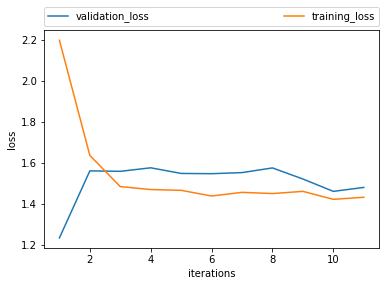

[1.2324675144972626,
 1.5597098624264751,
 1.557412487489206,
 1.5745659316027607,
 1.547038987830833,
 1.5458813199290522,
 1.5511701416086268,
 1.573988397916158,
 1.5198395958653204,
 1.4595757855309381,
 1.478802376323276]

In [67]:
train_save('gender', 0, 2)

In [ ]:
train_save('gender', 1, 2)

minibatch:49, epoch:1, iteration:49, training_error:3.191000535488129, validation_error:3.3574771305610396
Best loss improvement from inf to 3.3574771305610396 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.8078145122528078, validation_error:2.8745162404816726
Best loss improvement from 3.3574771305610396 to 2.8745162404816726 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.749586081504822, validation_error:2.8314714760615907
Best loss improvement from 2.8745162404816726 to 2.8314714760615907 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.7122743844985964, validation_error:2.7983778427387107
Best loss improvement from 2.8314714760615907 to 2.7983778427387107 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:2.691679878234863, validation_error:2.810852420741114
minibatch:39, epoch:2, iteration:299, training_error:2.6989133548736572, validation_error:2.746681879306662
Best loss improvement from 2.7983778427387107 to 

minibatch:89, epoch:12, iteration:2949, training_error:1.2109227311611175, validation_error:1.0191589429460723
minibatch:139, epoch:12, iteration:2999, training_error:1.0882925081253052, validation_error:1.5836376321726833
Patience ran out at 2999. Ending training


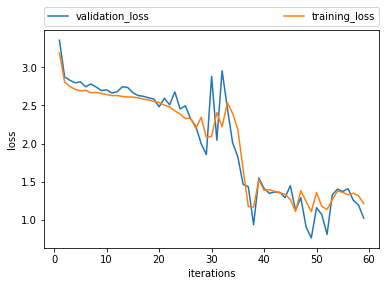

[3.3574771305610396,
 2.8745162404816726,
 2.8314714760615907,
 2.7983778427387107,
 2.810852420741114,
 2.746681879306662,
 2.7825443415806212,
 2.7424790612582504,
 2.6955151311282455,
 2.704531768272663,
 2.663915593048622,
 2.680838305374672,
 2.7459811999880035,
 2.737264731834675,
 2.6682363214163947,
 2.630651087596499,
 2.6208102456454574,
 2.600526143764627,
 2.585395837652272,
 2.48240222602055,
 2.594973292844049,
 2.5089624832416404,
 2.679051711641509,
 2.4537874747966897,
 2.4960909876330146,
 2.324349592471945,
 2.224405683320144,
 1.9993431403719146,
 1.855266439503637,
 2.8828802026551346,
 2.0438794596441863,
 2.957335488549594,
 2.4656829094064645,
 2.010701434365634,
 1.8256522992561603,
 1.4647642949531818,
 1.4310808140656044,
 0.932743933694116,
 1.5462343610566238,
 1.4098292753614228,
 1.3454205537664479,
 1.362852380193513,
 1.3587737042328407,
 1.2886051761692967,
 1.4466153958748127,
 1.1235318348325531,
 1.28814920474743,
 0.9050203335696253,
 0.75934457778

In [69]:
train_save('gender', 2, 2)

minibatch:49, epoch:1, iteration:49, training_error:3.1916736364364624, validation_error:3.469370225380207
Best loss improvement from inf to 3.469370225380207 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.820012216567993, validation_error:2.8869029900123335
Best loss improvement from 3.469370225380207 to 2.8869029900123335 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.7445696640014647, validation_error:2.8287454802414467
Best loss improvement from 2.8869029900123335 to 2.8287454802414467 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.7184881210327148, validation_error:2.7960363996439965
Best loss improvement from 2.8287454802414467 to 2.7960363996439965 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:2.7033063316345216, validation_error:2.7910538788499504
Best loss improvement from 2.7960363996439965 to 2.7910538788499504 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:2.6896013116836546, valid

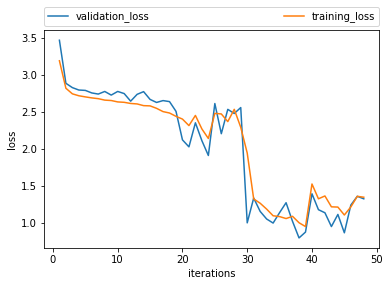

[3.469370225380207,
 2.8869029900123335,
 2.8287454802414467,
 2.7960363996439965,
 2.7910538788499504,
 2.7566536788282723,
 2.7415125616665543,
 2.7765914571696313,
 2.727597006436052,
 2.776852558399069,
 2.7482007125328325,
 2.6453399082710005,
 2.737896606839936,
 2.774257380386879,
 2.6689545286112817,
 2.6280819218734215,
 2.6531216111676446,
 2.6395510229571113,
 2.5082049452025315,
 2.1220529572717073,
 2.0274934645356804,
 2.352996826171875,
 2.110964191370997,
 1.9107505781897183,
 2.6134424867301154,
 2.2053439617156982,
 2.53466037224079,
 2.478810450126385,
 2.558802448470017,
 0.9997600892494465,
 1.3354118075864068,
 1.1544763754154075,
 1.0518160071866265,
 0.996871150773147,
 1.1382433628213817,
 1.2719661737310475,
 1.019274943861468,
 0.7959734406964533,
 0.8749072695600575,
 1.3929436700097446,
 1.1777343811659977,
 1.1360640505264545,
 0.9498186522516711,
 1.1133623595895439,
 0.8652707132799872,
 1.2400316123304695,
 1.3589154009161324,
 1.3246813683674252]

In [70]:
train_save('gender', 3, 2)

minibatch:49, epoch:1, iteration:49, training_error:3.3490875148773194, validation_error:3.362306833267212
Best loss improvement from inf to 3.362306833267212 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.8005097770690917, validation_error:2.798192180436233
Best loss improvement from 3.362306833267212 to 2.798192180436233 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.734566249847412, validation_error:2.791710532944778
Best loss improvement from 2.798192180436233 to 2.791710532944778 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.7056485843658447, validation_error:2.8079228565610688
minibatch:249, epoch:1, iteration:249, training_error:2.6927317667007444, validation_error:2.8029709520011115
minibatch:44, epoch:2, iteration:299, training_error:2.6779633808135985, validation_error:2.7853660008002974
Best loss improvement from 2.791710532944778 to 2.7853660008002974 in epoch 2
minibatch:94, epoch:2, iteration:349, training_error:2

minibatch:94, epoch:12, iteration:2899, training_error:1.0718629920482636, validation_error:0.8897385062842533
Best loss improvement from 0.9526152014732361 to 0.8897385062842533 in epoch 12
minibatch:144, epoch:12, iteration:2949, training_error:1.00199840426445, validation_error:0.8121971179699076
Best loss improvement from 0.8897385062842533 to 0.8121971179699076 in epoch 12
minibatch:194, epoch:12, iteration:2999, training_error:1.0568037283420564, validation_error:0.9494888145348122
minibatch:244, epoch:12, iteration:3049, training_error:1.097212860584259, validation_error:1.456218304305241
minibatch:39, epoch:13, iteration:3099, training_error:1.3269589304924012, validation_error:1.2552168389846539
minibatch:89, epoch:13, iteration:3149, training_error:1.2652825474739076, validation_error:1.3088124949356605
minibatch:139, epoch:13, iteration:3199, training_error:1.2327553606033326, validation_error:1.1931058106751278
minibatch:189, epoch:13, iteration:3249, training_error:1.14169

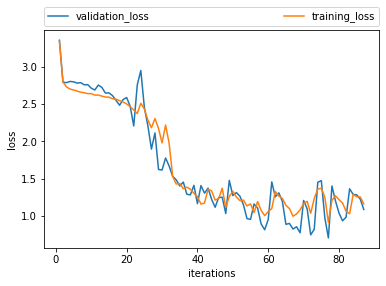

[3.362306833267212,
 2.798192180436233,
 2.791710532944778,
 2.8079228565610688,
 2.8029709520011115,
 2.7853660008002974,
 2.7916928077566214,
 2.7629439748566726,
 2.764698521844272,
 2.7172836681892134,
 2.6929006247684875,
 2.759695793020314,
 2.72660728980755,
 2.6514095849004287,
 2.6540848633338667,
 2.617172701605435,
 2.552959072178808,
 2.4875858076687516,
 2.564512540554178,
 2.5915973104279617,
 2.471631568053673,
 2.209400514076496,
 2.7624524379598685,
 2.9550529595079094,
 2.4580629200770936,
 2.210290711501549,
 1.8979422922792106,
 2.115161344922822,
 1.6236238191867698,
 1.6157352143320545,
 1.7777855971763874,
 1.6692919073433712,
 1.5311630676532615,
 1.4844491152927792,
 1.4015553326442325,
 1.4541412406954273,
 1.290336129994228,
 1.281124369851474,
 1.409711860377213,
 1.1633714149738181,
 1.4067958552261879,
 1.3044980497195804,
 1.37257922312309,
 1.2223698928438385,
 1.1146677115867878,
 1.2464856382074028,
 1.2493860536608203,
 1.0308388862116584,
 1.47684799

In [71]:
train_save('gender', 4, 2)

In [26]:
print(get_performance_of_a_model("test", "gender", 0, 0))
print(get_performance_of_a_model("test", "gender", 1, 0))
print(get_performance_of_a_model("test", "gender", 2, 0))
print(get_performance_of_a_model("test", "gender", 3, 0))
print(get_performance_of_a_model("test", "gender", 4, 0))

{'accuracy': 0.4886448714749189}
{'accuracy': 0.0}
{'accuracy': 0.0}
{'accuracy': 0.5232067510548524}
{'accuracy': 0.5368177880450477}


In [27]:
print(get_performance_of_a_model("test", "gender", 0, 1))
print(get_performance_of_a_model("test", "gender", 1, 1))
print(get_performance_of_a_model("test", "gender", 2, 1))
print(get_performance_of_a_model("test", "gender", 3, 1))
print(get_performance_of_a_model("test", "gender", 4, 1))

{'accuracy': 0.4886448714749189}
{'accuracy': 0.0}
{'accuracy': 0.4418677530554685}
{'accuracy': 0.5494273658830621}
{'accuracy': 0.5284435460583309}


In [28]:
print(get_performance_of_a_model("test", "gender", 0, 2))
print(get_performance_of_a_model("test", "gender", 1, 2))
print(get_performance_of_a_model("test", "gender", 2, 2))
print(get_performance_of_a_model("test", "gender", 3, 2))
print(get_performance_of_a_model("test", "gender", 4, 2))

{'accuracy': 0.5113551285250811}
{'accuracy': 0.0}
{'accuracy': 0.44468818552178}
{'accuracy': 0.5464135021097046}
{'accuracy': 0.5434594282414091}


In [29]:
print(get_performance_of_a_model("test", "age", 0, 0))
print(get_performance_of_a_model("test", "age", 1, 0))
print(get_performance_of_a_model("test", "age", 2, 0))
print(get_performance_of_a_model("test", "age", 3, 0))
print(get_performance_of_a_model("test", "age", 4, 0))

{'accuracy': 0.032205746061167745, 'one-off accuracy': 0.08317886932344763}
{'accuracy': 0.20477265398258626, 'one-off accuracy': 0.5253144147049339}
{'accuracy': 0.14225816112608566, 'one-off accuracy': 0.3360287511230907}
{'accuracy': 0.0010084033613445378, 'one-off accuracy': 0.006050420168067227}
{'accuracy': 0.27159490928784186, 'one-off accuracy': 0.4668291362036285}


In [30]:
print(get_performance_of_a_model("test", "age", 0, 1))
print(get_performance_of_a_model("test", "age", 1, 1))
print(get_performance_of_a_model("test", "age", 2, 1))
print(get_performance_of_a_model("test", "age", 3, 1))
print(get_performance_of_a_model("test", "age", 4, 1))

{'accuracy': 0.366079703429101, 'one-off accuracy': 0.530583873957368}
{'accuracy': 0.04708158658497259, 'one-off accuracy': 0.2492744276039987}
{'accuracy': 0.21203953279424978, 'one-off accuracy': 0.37376460017969454}
{'accuracy': 0.26621848739495796, 'one-off accuracy': 0.6433613445378151}
{'accuracy': 0.19496344435418358, 'one-off accuracy': 0.3839696723531005}


In [31]:
print(get_performance_of_a_model("test", "age", 0, 2))
print(get_performance_of_a_model("test", "age", 1, 2))
print(get_performance_of_a_model("test", "age", 2, 2))
print(get_performance_of_a_model("test", "age", 3, 2))
print(get_performance_of_a_model("test", "age", 4, 2))

{'accuracy': 0.0, 'one-off accuracy': 0.032205746061167745}
{'accuracy': 0.15124153498871332, 'one-off accuracy': 0.4030957755562722}
{'accuracy': 0.0, 'one-off accuracy': 0.0}
{'accuracy': 0.16436974789915967, 'one-off accuracy': 0.5028571428571429}
{'accuracy': 0.0, 'one-off accuracy': 0.0}


In [32]:
print(get_performance_of_a_model("test", "both", 0, 0))
print(get_performance_of_a_model("test", "both", 1, 0))
print(get_performance_of_a_model("test", "both", 2, 0))
print(get_performance_of_a_model("test", "both", 3, 0))
print(get_performance_of_a_model("test", "both", 4, 0))

{'accuracy': 0.1719515339004898, 'one-off accuracy': 0.25754060324825984, 'gender accuracy': 0.48234080948698116, 'age accuracy': 0.18973962361433358, 'one-off age accuracy': 0.3109048723897912}
{'accuracy': 0.09717138103161398, 'one-off accuracy': 0.2292845257903494, 'gender accuracy': 0.5198003327787022, 'age accuracy': 0.1237936772046589, 'one-off age accuracy': 0.27653910149750416}
{'accuracy': 0.12463953860942006, 'one-off accuracy': 0.2242870874719641, 'gender accuracy': 0.5334828580583146, 'age accuracy': 0.17782761935277155, 'one-off age accuracy': 0.4299903876962512}
{'accuracy': 0.017096999302163293, 'one-off accuracy': 0.034891835310537335, 'gender accuracy': 0.4539427773900907, 'age accuracy': 0.2292393579902303, 'one-off age accuracy': 0.4204466154919749}
{'accuracy': 0.15854738706820196, 'one-off accuracy': 0.28520814880425155, 'gender accuracy': 0.5341009743135519, 'age accuracy': 0.19250073811632715, 'one-off age accuracy': 0.35016238559196927}


In [33]:
print(get_performance_of_a_model("test", "both", 0, 1))
print(get_performance_of_a_model("test", "both", 1, 1))
print(get_performance_of_a_model("test", "both", 2, 1))
print(get_performance_of_a_model("test", "both", 3, 1))
print(get_performance_of_a_model("test", "both", 4, 1))

{'accuracy': 0.1719515339004898, 'one-off accuracy': 0.25754060324825984, 'gender accuracy': 0.48234080948698116, 'age accuracy': 0.18973962361433358, 'one-off age accuracy': 0.3109048723897912}
{'accuracy': 0.11547420965058236, 'one-off accuracy': 0.3194675540765391, 'gender accuracy': 0.49217970049916804, 'age accuracy': 0.11680532445923461, 'one-off age accuracy': 0.4415973377703827}
{'accuracy': 0.07401473886574816, 'one-off accuracy': 0.1169496956103813, 'gender accuracy': 0.5533482858058315, 'age accuracy': 0.09772508811278437, 'one-off age accuracy': 0.25793015059275876}
{'accuracy': 0.20376831821353802, 'one-off accuracy': 0.39427773900907187, 'gender accuracy': 0.5907187718073971, 'age accuracy': 0.23866015352407538, 'one-off age accuracy': 0.444870900209351}
{'accuracy': 0.0, 'one-off accuracy': 0.05698258045467966, 'gender accuracy': 0.0, 'age accuracy': 0.0, 'one-off age accuracy': 0.0}


In [34]:
print(get_performance_of_a_model("test", "both", 0, 2))
print(get_performance_of_a_model("test", "both", 1, 2))
print(get_performance_of_a_model("test", "both", 2, 2))
print(get_performance_of_a_model("test", "both", 3, 2))
print(get_performance_of_a_model("test", "both", 4, 2))

{'accuracy': 0.07063676205207528, 'one-off accuracy': 0.11729827275070895, 'gender accuracy': 0.5176591905130188, 'age accuracy': 0.08842485176591905, 'one-off age accuracy': 0.17066254189224025}
{'accuracy': 0.06855241264559069, 'one-off accuracy': 0.1600665557404326, 'gender accuracy': 0.5194675540765391, 'age accuracy': 0.07753743760399334, 'one-off age accuracy': 0.2422628951747088}
{'accuracy': 0.023389939122076257, 'one-off accuracy': 0.050304389618711955, 'gender accuracy': 0.5533482858058315, 'age accuracy': 0.09740467798782441, 'one-off age accuracy': 0.16725408522909324}
{'accuracy': 0.04745289602233078, 'one-off accuracy': 0.13538032100488487, 'gender accuracy': 0.345778087927425, 'age accuracy': 0.04989532449406839, 'one-off age accuracy': 0.133635729239358}
{'accuracy': 0.002066725715972837, 'one-off accuracy': 0.11426040744021258, 'gender accuracy': 0.4658990256864482, 'age accuracy': 0.03602007676409802, 'one-off age accuracy': 0.17921464422793032}


### How to run?

1.   **Run `train_save()`:**


> You can do this for different combinations of **`c`**, **`fold`**, and **`train_transform_index`**, where **`c={'age','gender'}`**, **`fold={0,1,2,3,4}`**, and **`train_transform_index={0,1,2}`**.

> I suggest you to first train the network on all the folds for **either** **`age`** or **`gender`** and then proceed to the setp 2. Then, follow the same steps for the other class. Also, use **`train_transform_index=2`** as it gives smaller validation error due to random flipping and cropping.

> **Note:** It is just the network's architecture that is the same for age and gender. They both are trained independently. Ultimately, we will be having two different networks with the same architecture, one to classify age and the other to classify gender.

2. **Picking the best model:**

> Call **`pick_best_model()`** on either **`age`** or **`gender`**.

3. **Know the performance:**

> Call **`get_performance()`** on either **`age`** or **`gender`** to know the final performance of the network on the test set.



